# <div class="alert alert-info"> 1 Overview - Recommendation Engines </div>

This analysis employes and applies different types of recommendation engines to movie dataset

---
# <div class="alert alert-info"> 2 Import libraries and data </div>

## <font color=red>2.1.  Library</font>

In [10]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.style.use('ggplot')
# sns.set_style('dark')
%matplotlib inline

import os
import sys

import time
import datetime
from datetime import datetime
from importlib import reload
from collections import Counter
from sklearn.utils import shuffle
from sortedcontainers import SortedList

from scipy.sparse import csc_matrix
from sparsesvd import sparsesvd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>"))

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# display various ranges 
pd.options.display.float_format = '{:.3f}'.format

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


## <font color=red>2.2.  Defined function</font>

In [2]:
def rmse(prediction, label):
    prediction = prediction[label.nonzero()].flatten()
    label = label[label.nonzero()].flatten()
    
    return sqrt(mean_squared_error(prediction, label))

## <font color=red>2.3. Data</font>

The dataset is MovieLens dataset - the most common dataset useed in building RS  

https://dl.acm.org/doi/10.1145/2827872

https://grouplens.org/datasets/movielens/

The dataset consists of just over 100,000 ratings applied to over 9,000 movies by approximately 600 users. The movies dataset consists of the ID of over 9000 the movies(movieId), the corresponding title (title) and genre of each movie(genres).

In [3]:
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')
df_users = df_ratings[['userId','movieId','rating']].copy()

In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.500,1260759144
1,1,1029,3.000,1260759179
2,1,1061,3.000,1260759182
3,1,1129,2.000,1260759185
4,1,1172,4.000,1260759205


In [6]:
df_tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [7]:
print('{} rows and {} unique movies in movies'.format(df_movies.shape[0], df_movies.movieId.nunique()))
print('{} rows and {} unique movies in ratings'.format(df_ratings.shape[0], df_ratings.movieId.nunique()))
print('{} rows and {} unique movies in tags'.format(df_tags.shape[0], df_tags.movieId.nunique()))
print('{} unique users and {} unique movies in ratings'.format(df_ratings.userId.nunique(), df_ratings.movieId.nunique()))

9125 rows and 9125 unique movies in movies
100004 rows and 9066 unique movies in ratings
1296 rows and 689 unique movies in tags
671 unique users and 9066 unique movies in ratings


---
# <div class="alert alert-info"> 3. Data Exploration </div>

## <font color=red>3.1. Investigating rating data</font>

In [8]:
N = len(df_ratings.userId.unique())  # Num of users
M = df_movies.movieId.nunique()   # Num of items

print('There are {} unique users and {} unique movies in this dataset'.format(N, M))

There are 671 unique users and 9125 unique movies in this dataset


In [9]:
# rated movies
rating_count_df = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])

# unrated movies
total_count = N * M
rating_zero_count = total_count - rating_count_df['count'].sum()

rating_count_df = rating_count_df.append(pd.DataFrame({'count': rating_zero_count}, index=[0]), verify_integrity=True).sort_index()
rating_count_df

,count
0.000,6022871
0.500,1101
1.000,3326
1.500,1687
2.000,7271
2.500,4449
3.000,20064
3.500,10538
4.000,28750
4.500,7723


Text(0, 0.5, 'Number of ratings')

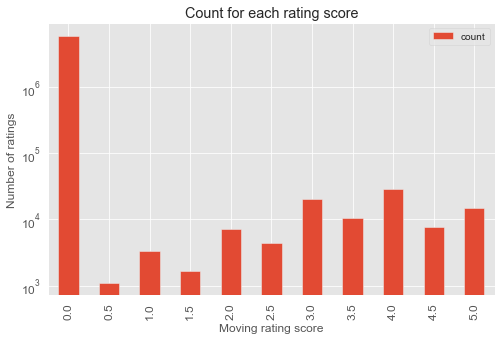

In [11]:
ax = rating_count_df.reset_index().rename(columns={'index':  'rating score'}).plot(
    x = 'rating score',
    y = 'count',
    kind = 'bar',
    figsize = (8, 5),
    title = 'Count for each rating score',
    logy = True,
    fontsize = 12)
ax.set_xlabel("Moving rating score")
ax.set_ylabel("Number of ratings")

By knowing the count of movies, users and movie ratings, we can better understand three things:

+ A lot of values in user-item matrix are zero. Thus, we're dealing with extremly sparse data. In such a case, we need to work with a scipy-sparse matrix to avoid overflow and wasted memory.
+ To get an idea about a user's taste, we need a user who's rated at least 50 out of 9000 movies
+ Similarly, to derive predictions regarding movie recommendations, we need movies that have been rated at least 50 times

## <font color=red>2. Investigating movie-rating data</font>

### <font color=blue>Avg rating and popularity per movie

In [12]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movie_summary_df = pd.DataFrame(df_ratings.groupby(['movieId'])['rating'].mean())
movie_summary_df['count'] = df_ratings.groupby(['movieId'])['rating'].count()
movie_summary_df.reset_index(drop=False,inplace=True)
movie_summary_df.columns = ['movieId','movie_rating', 'movie_count']
df_movies = pd.merge(df_movies, movie_summary_df, on='movieId', how='left')

df_movies.head()

,movieId,title,genres,movie_rating,movie_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872,247.000
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.402,107.000
2,3,Grumpier Old Men (1995),Comedy|Romance,3.161,59.000
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.385,13.000
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000


### <font color=blue>top 10 popular / most rated movies

In [14]:
df_movies.sort_values('movie_count', ascending=False).head(10)

,movieId,title,genres,movie_rating,movie_count
321,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.054,341.000
266,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.256,324.000
284,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.487,311.000
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.138,304.000
232,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.222,291.000
427,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.706,274.000
2062,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.183,259.000
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872,247.000
472,527,Schindler's List (1993),Drama|War,4.303,244.000
522,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.006,237.000


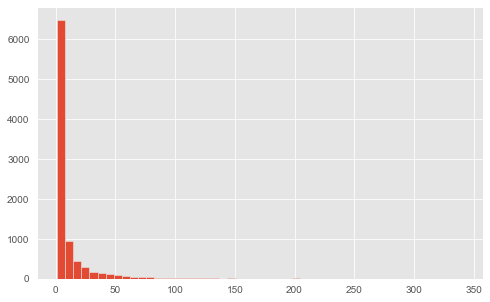

In [17]:
plt.figure(figsize=(8,5))
df_movies['movie_count'].hist(bins=50)
plt.show()

### <font color=blue>top 10 rating movies/ top N average rating of each movie

In [16]:
df_movies[df_movies['movie_count'] > 50].sort_values('movie_rating', ascending=False).head(10)

,movieId,title,genres,movie_rating,movie_count
695,858,"Godfather, The (1972)",Crime|Drama,4.487,200.000
284,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.487,311.000
734,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery,4.387,62.000
977,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.385,135.000
48,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.371,201.000
1006,1252,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,4.336,76.000
725,904,Rear Window (1954),Mystery|Thriller,4.315,92.000
960,1203,12 Angry Men (1957),Drama,4.304,74.000
472,527,Schindler's List (1993),Drama|War,4.303,244.000
4432,6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.297,69.000


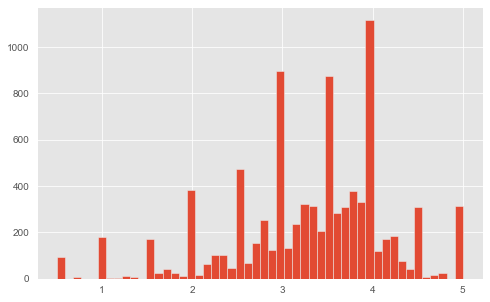

In [18]:
plt.figure(figsize=(8,5))
df_movies['movie_rating'].hist(bins=50)
plt.show()

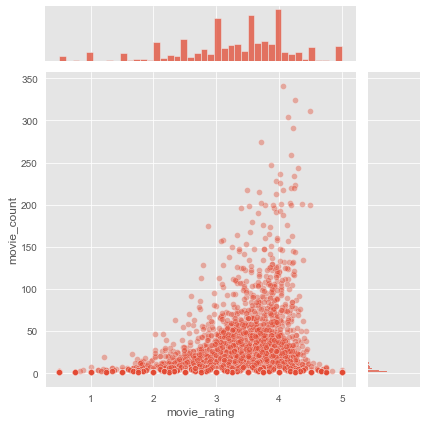

In [19]:
sns.jointplot(x='movie_rating', y ='movie_count', data=df_movies, alpha=0.4)
plt.show()

## <font color=red>3.3. Investigating user-rating data</font>

### <font color=blue>Avg rating and frequency per user

In [20]:
df_users = pd.DataFrame(df_ratings.groupby(['userId'])['rating'].count())
df_users['avg_rating'] = df_ratings.groupby(['userId'])['rating'].mean()
df_users.reset_index(inplace = True)
df_users.columns = ['userId','user_count','user_rating']
df_users.sort_values(['user_count'], ascending=False).head(10)

,userId,user_count,user_rating
546,547,2391,3.367
563,564,1868,3.552
623,624,1735,2.894
14,15,1700,2.622
72,73,1610,3.374
451,452,1340,3.189
467,468,1291,2.966
379,380,1063,3.366
310,311,1019,3.006
29,30,1011,3.765


## <font color=red>3.4. Filter data</font>

### <font color=blue>get movies rated at least 50 times

In [21]:
movie_count_df = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
movie_count_df.head()

,count
movieId,
1,247
2,107
3,59
4,13
5,56


In [22]:
popularity_threshold = 50
popular_movies = list(set(movie_count_df.query('count > @popularity_threshold').index))

popular_movie_df = df_movies[df_movies['movieId'].isin(popular_movies)]
print(popular_movie_df.shape)
popular_movie_df.head()

(444, 5)


,movieId,title,genres,movie_rating,movie_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872,247.000
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.402,107.000
2,3,Grumpier Old Men (1995),Comedy|Romance,3.161,59.000
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000
5,6,Heat (1995),Action|Crime|Thriller,3.885,104.000


### <font color=blue>get users making at least 50 ratings

In [23]:
ratings_threshold = 50
# get number of ratings by every user
user_count_df = pd.DataFrame(df_ratings.groupby('userId').size(), columns = ['count'])
active_users = list(set(user_count_df.query('count >= @ratings_threshold').index))
print(len(active_users))

427


### <font color=blue>get corresponding ratings data of these movies and active users

In [24]:
selected_ratings_df = df_ratings[(df_ratings['movieId'].isin(popular_movies)) &
                                 (df_ratings['userId'].isin(active_users))]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive user: ', selected_ratings_df.shape)                      

shape of original ratings data:  (100004, 4)
shape of ratings data after dropping both unpopular movies and inactive user:  (38133, 4)


In [25]:
selected_ratings_df.head()

,userId,movieId,rating,timestamp
20,2,10,4.000,835355493
21,2,17,5.000,835355681
22,2,39,5.000,835355604
23,2,47,4.000,835355552
24,2,50,4.000,835355586


In [26]:
selected_ratings_df.to_csv('ml-latest-small/ratings_filtered.csv', index=False)

---
# <div class="alert alert-info"> 4 Data Processing </div>

This section involves the following tasks:

1. Group tags by movie in ratings data
2. Combine info from column genres and tags. This text info is represented as a document storing additional relevant info for each movie
3. Apply tf-idf model to transform text data to numeric data

## <font color=red>4.1. Generate movie profile and user profile</font>

This step is to preprocess data for DNN model. From movies data and rating data, we generate more features  represent characteristics of each movie and each user. These features are then combine together to create a dataset that combine both movie and user featurs in order to train model and predict rating of each user for each movie

### <font color=blue>Generate Movie profile
    
In ordder to generate more features for movie, extract genres from genres column to set of genre features, if a movie has one of these genres, then the corresponding feature has value of 1, otherwise 0. 

In [28]:
df_movies.head()

,movieId,title,genres,movie_rating,movie_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872,247.000
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.402,107.000
2,3,Grumpier Old Men (1995),Comedy|Romance,3.161,59.000
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.385,13.000
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

df_movies['genres'] = df_movies['genres'].str.replace(pat="|", repl=" ")
df_movies['genres'] = df_movies['genres'].str.replace(pat="-", repl='')
bow = CountVectorizer(ngram_range=(0,1), stop_words='english')
bow.fit(df_movies['genres'])

genre_df = bow.transform(df_movies['genres'])
genre_df = pd.DataFrame(genre_df.toarray())
genre_df.columns = sorted(bow.vocabulary_.keys())
genre_df.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,filmnoir,genres,horror,imax,listed,musical,mystery,romance,scifi,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
columns = list(sorted(bow.vocabulary_.keys()))
freq_genre = genre_df[columns].sum(axis=0).sort_values(ascending=False)
freq_genre

drama          4365
comedy         3315
thriller       1729
action         1545
romance        1545
adventure      1117
crime          1100
horror          877
scifi           792
fantasy         654
children        583
mystery         543
documentary     495
animation       447
musical         394
war             367
western         168
imax            153
filmnoir        133
listed           18
genres           18
dtype: int64

In [32]:
selected_genres = sorted([var for var in freq_genre.index if freq_genre[var] >  200])
print(len(selected_genres))
print(selected_genres)

genre_df = genre_df[selected_genres]
genre_df.head()

16
['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war']


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# merge with df_movies to create movie_profile
genre_df['movieId'] = df_movies['movieId']
movie_profile = pd.merge(df_movies[['movieId','title','movie_rating','movie_count']], genre_df, how='left', on='movieId')
print(movie_profile.shape)
movie_profile.head()

(9125, 20)


,movieId,title,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war
0,1,Toy Story (1995),3.872,247.000,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0
1,2,Jumanji (1995),3.402,107.000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),3.161,59.000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale (1995),2.385,13.000,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,5,Father of the Bride Part II (1995),3.268,56.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [34]:
movie_profile.to_csv('ml-latest-small/movie_profife.csv',index=False)

### <font color=blue>Generate User profile

In [38]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
print(df_ratings.shape)
df_ratings.head()

(38133, 4)


,userId,movieId,rating,timestamp
0,2,10,4.000,835355493
1,2,17,5.000,835355681
2,2,39,5.000,835355604
3,2,47,4.000,835355552
4,2,50,4.000,835355586


In [39]:
df_movie_ratings = pd.merge(df_ratings, movie_profile, how='left', on='movieId')
print(df_movie_ratings.shape)
df_movie_ratings.head()

(38133, 23)


,userId,movieId,rating,timestamp,title,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war
0,2,10,4.000,835355493,GoldenEye (1995),3.451,122.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2,17,5.000,835355681,Sense and Sensibility (1995),3.924,86.000,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,2,39,5.000,835355604,Clueless (1995),3.550,120.000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,2,47,4.000,835355552,Seven (a.k.a. Se7en) (1995),4.035,201.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,2,50,4.000,835355586,"Usual Suspects, The (1995)",4.371,201.000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


In [40]:
df_users = df_ratings[['userId','movieId','rating']].copy()
user_profile = df_users.copy()
genre_count = {}
genre_rating = {}

for var in selected_genres:
    print(var)
    r_df = df_movie_ratings[df_movie_ratings[var] > 0]
    r_df = pd.DataFrame(r_df.groupby(['userId'])['rating'].mean())
    r_df.columns = [var + '_rating']
    
    c_df = df_movie_ratings[df_movie_ratings[var] > 0]
    c_df = pd.DataFrame(c_df.groupby(['userId'])['rating'].count())
    c_df.columns = [var + '_count']
    
    user_profile = pd.merge(user_profile, r_df, how='left', on='userId')
    user_profile = pd.merge(user_profile, c_df, how='left', on='userId')

action
adventure
animation
children
comedy
crime
documentary
drama
fantasy
horror
musical
mystery
romance
scifi
thriller
war


In [41]:
print(user_profile.shape)
user_profile.head(5)

(38133, 35)


,userId,movieId,rating,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count
0,2,10,4.000,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000
1,2,17,5.000,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000
2,2,39,5.000,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000
3,2,47,4.000,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000
4,2,50,4.000,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000


In [43]:
user_profile.to_csv('ml-latest-small/user_profife.csv',index=False)

### <font color=blue>Combine both user profile and movie profile

In [44]:
df = df_ratings[['userId','movieId','rating']]
df = df.merge(movie_profile.drop(['title'],axis=1), how='left', on='movieId')
df = df.merge(user_profile.drop(['rating'],axis=1), how='left', on=('userId','movieId'))
df['Index'] = df.index
print(df.shape)
df.head()

(38133, 54)


,userId,movieId,rating,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count,Index
0,2,10,4.000,3.451,122.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,0
1,2,17,5.000,3.924,86.000,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,1
2,2,39,5.000,3.550,120.000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,2
3,2,47,4.000,4.035,201.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,3
4,2,50,4.000,4.371,201.000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,NaN,NaN,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,4


In [45]:
df.to_csv('ml-latest-small/user_movie_profife.csv',index=False)

## <font color=red>4.2. Combine tag to movie to get more info

In [46]:
print(df_tags.shape)
df_tags.head(6)

(1296, 4)


,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765
5,15,35957,short,1141391873


In [47]:
df_tags = pd.merge(df_movies, df_tags[['userId', 'movieId', 'tag']], on='movieId', how='left')
print(df_tags.shape)
df_tags.head()

(9732, 7)


,movieId,title,genres,movie_rating,movie_count,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.872,247.000,501.000,Pixar
1,2,Jumanji (1995),Adventure Children Fantasy,3.402,107.000,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy Romance,3.161,59.000,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2.385,13.000,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000,431.000,steve martin


In [48]:
df_tags[df_tags['movieId'] == 47]

,movieId,title,genres,movie_rating,movie_count,userId,tag
45,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,biblical
46,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,crime
47,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,dark
48,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,disturbing
49,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,greed
50,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,horror
51,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,serial killer
52,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,364.000,violent
53,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,501.000,psychology
54,47,Seven (a.k.a. Se7en) (1995),Mystery Thriller,4.035,201.000,501.000,twist ending


In [49]:
df_tags.fillna("", inplace=True)
df_tags = pd.DataFrame(df_tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
df_tags.head()

,tag
movieId,
1,{Pixar}
2,{}
3,{}
4,{}
5,{steve martin}


In [50]:
print(df_tags.shape)
df_tags[df_tags.index == 47]

(9125, 1)


,tag
movieId,
47,{biblical crime dark disturbing greed horror s...


In [51]:
df_movies = pd.merge(df_movies, df_tags, left_on='movieId', right_index=True, how='left')
df_movies.head()

,movieId,title,genres,movie_rating,movie_count,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.872,247.000,{Pixar}
1,2,Jumanji (1995),Adventure Children Fantasy,3.402,107.000,{}
2,3,Grumpier Old Men (1995),Comedy Romance,3.161,59.000,{}
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2.385,13.000,{}
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000,{steve martin}


### <font color=blue> add genres to movie 

In [52]:
df_movies['document'] = df_movies[['genres','tag']].apply(lambda x: ' '.join(x), axis=1)
df_movies.head()

,movieId,title,genres,movie_rating,movie_count,tag,document
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.872,247.000,{Pixar},Adventure Animation Children Comedy Fantasy {P...
1,2,Jumanji (1995),Adventure Children Fantasy,3.402,107.000,{},Adventure Children Fantasy {}
2,3,Grumpier Old Men (1995),Comedy Romance,3.161,59.000,{},Comedy Romance {}
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2.385,13.000,{},Comedy Drama Romance {}
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000,{steve martin},Comedy {steve martin}


In [53]:
df_movies.shape

(9125, 7)

In [54]:
df_movies.to_csv('ml-latest-small/movie_tag_genres.csv', index=False)

## <font color=red>4.3. Feature Extraction - Transform text to numeric features

### <font color=blue> Convert document to Tf-idf

The Tf*Idf algorithm is used to weight a keyword in any document and assign the importance to that keyword based on the number of times it appears in the document. Put simply, the higher the Tf*Idf score (weight), the rarer and more important the term, and vice versa

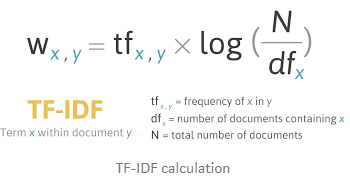

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(0,1), min_df=0.0001, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_movies['document'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df_movies.index.tolist())
print(tfidf_df.shape)

(9125, 719)


In [56]:
tfidf.vocabulary_

{'adventure': 12,
 'animation': 28,
 'children': 97,
 'comedy': 116,
 'fantasy': 209,
 'pixar': 490,
 'romance': 539,
 'drama': 174,
 'steve': 599,
 'martin': 405,
 'action': 6,
 'crime': 132,
 'thriller': 643,
 'horror': 311,
 'mystery': 438,
 'scifi': 560,
 'documentary': 172,
 'imax': 325,
 'war': 700,
 'biblical': 58,
 'dark': 144,
 'disturbing': 171,
 'greed': 271,
 'serial': 568,
 'killer': 370,
 'violent': 695,
 'psychology': 508,
 'twist': 677,
 'ending': 190,
 'musical': 436,
 'adam': 8,
 'sandler': 547,
 'cult': 137,
 'film': 227,
 'scorsese': 561,
 'social': 582,
 'commentary': 119,
 'ron': 541,
 'howard': 312,
 'tom': 651,
 'hanks': 282,
 'ei': 185,
 'muista': 432,
 'western': 705,
 'filmnoir': 229,
 'hugh': 313,
 'grant': 267,
 'ethan': 196,
 'hawke': 289,
 'holes90s': 309,
 'aging': 16,
 'ang': 27,
 'lee': 381,
 'cooking': 125,
 'food': 234,
 'relationships': 521,
 'meg': 412,
 'ryan': 545,
 'school': 556,
 'stylized': 614,
 'surreal': 620,
 'surrealism': 621,
 'visceral'

In [57]:
tfidf_df.to_pickle('ml-latest-small/tfidf_matrix.pkl')

---
# <div class="alert alert-info"> 5. Popularity based recommendations </div>

In [46]:
def create_popularity_recommendation(data, user_id, item_id, n_items):
    
    # Calculate count of user_ids for each movie as recommendation score
    data_grouped = data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    data_grouped.rename(columns = {user_id: 'score'}, inplace=True)
    
    # Sort the movies based upon recommendation score
    data_sorted = data_grouped.sort_values(['score', item_id], ascending= [0,1])
    
    # Generate a recommendation rank based upon score
    data_sorted['Rank'] = data_sorted['score'].rank(ascending=0, method='first')
    
    # Get the top 10 recommendations
    popularity_recommendations = data_sorted.head(n_items)
    
    return popularity_recommendations

popularity_recommendations = create_popularity_recommendation(df_ratings,'userId','movieId',10)
popularity_recommendations = popularity_recommendations.merge(df_movies, how='left', on='movieId')
popularity_recommendations

,movieId,score,Rank,title,genres,movie_rating,movie_count,tag,document
0,356,279,1.000,Forrest Gump (1994),Comedy Drama Romance War,4.054,341.000,{},Comedy Drama Romance War {}
1,296,257,2.000,Pulp Fiction (1994),Comedy Crime Drama Thriller,4.256,324.000,{intense r:violence tarantino dark comedy Quen...,Comedy Crime Drama Thriller {intense r:violenc...
2,318,241,3.000,"Shawshank Redemption, The (1994)",Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...,Crime Drama {friendship Morgan Freeman narrate...
3,593,238,4.000,"Silence of the Lambs, The (1991)",Crime Horror Thriller,4.138,304.000,{Katso Sanna!},Crime Horror Thriller {Katso Sanna!}
4,260,236,5.000,Star Wars: Episode IV - A New Hope (1977),Action Adventure SciFi,4.222,291.000,{cult classic Science Fiction nerdy Science Fi...,Action Adventure SciFi {cult classic Science F...
5,2571,224,6.000,"Matrix, The (1999)",Action SciFi Thriller,4.183,259.000,{sci-fi virtual reality philosophy},Action SciFi Thriller {sci-fi virtual reality ...
6,480,217,7.000,Jurassic Park (1993),Action Adventure SciFi Thriller,3.706,274.000,{},Action Adventure SciFi Thriller {}
7,1270,208,8.000,Back to the Future (1985),Adventure Comedy SciFi,4.015,226.000,{},Adventure Comedy SciFi {}
8,1196,204,9.000,Star Wars: Episode V - The Empire Strikes Back...,Action Adventure SciFi,4.233,234.000,{},Action Adventure SciFi {}
9,527,203,10.000,Schindler's List (1993),Drama War,4.303,244.000,{},Drama War {}


---
# <div class="alert alert-info"> 6 Content-based recommendation </div>

##  <font color=red>6.1. Memory-based: Movie Profile Similarity</font>

In this model, each item is stored as a vector of its attributes in an n-dimensional space, and the angles between the vectors are calculated to determine the similarity between the vectors. Cosine will increase as the angle between vectors with decreases, which signifies more similarity.

### <font color=blue> 1. Load processed data

In [281]:
path = "ml-latest-small/"
with open(f'{path}tfidf_matrix.pkl', 'rb') as f:
    tfidf = pickle.load(f)
    
print(tfidf.shape)
tfidf.head()

(9125, 719)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.272,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.353,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.177,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

### <font color=blue> 2. Dimensionality Reduction with AutoEncodorDecoder
 
1.	An auto-encoder is a kind of intersection between supervised and unsupervised learning that is commonly used for dimensionality reduction and feature discovery. More precisely, an auto-encoder is a feedforward neural network that is trained to predict the input itself. 


2. To prevent the system from learning the trivial identity mapping, the hidden layer in the middle is usually constrained to be a narrow bottleneck. The system can minimize the reconstruction error by ensuring the hidden units capture the most relevant aspects of the data which can be considered as the lower representation of data

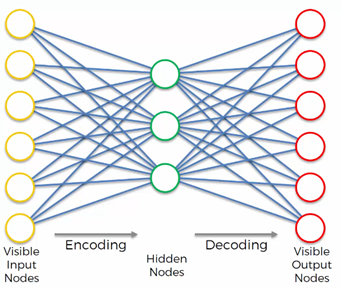


### <font color=blue> 3. Import libraries and define DNN architecture

#### Deep Learning libraries

In [282]:
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import datetime

#### Model architecture

In [283]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()

# No of Neurons in each layer
input_dim = tfidf.shape[1]
encoding_dim = input_dim/2
latent_dim = 25

input_layer = Input(shape=(input_dim, ))
#encoder = Dense(int(encoding_dim), activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(input_layer)
encoder = Dense(int(latent_dim), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation="tanh")(encoder)
decoder = Dense(int(input_dim), activation="relu")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 719)]             0         
                                                                 
 dense (Dense)               (None, 359)               258480    
                                                                 
 dense_1 (Dense)             (None, 25)                9000      
                                                                 
 dense_2 (Dense)             (None, 359)               9334      
                                                                 
 dense_3 (Dense)             (None, 719)               258840    
                                                                 
Total params: 535,654
Trainable params: 535,654
Non-trainable params: 0
_________________________________________________________________


In [284]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-2]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

### <font color=blue> 4. Training model

In [285]:
nb_epoch = 30
batch_size = 100
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(tfidf, 
                          tfidf, 
                          epochs=nb_epoch, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          validation_split=0.1, 
                          verbose=1).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/30
83/83 [==============================] - 1s 10ms/step - loss: 5.9955e-04 - val_loss: 2.3808e-04
Epoch 2/30
83/83 [==============================] - 0s 5ms/step - loss: 1.2635e-04 - val_loss: 1.9515e-04
Epoch 3/30
83/83 [==============================] - 0s 4ms/step - loss: 1.1628e-04 - val_loss: 1.9208e-04
Epoch 4/30
83/83 [==============================] - 0s 5ms/step - loss: 1.1418e-04 - val_loss: 1.9106e-04
Epoch 5/30
83/83 [==============================] - 0s 5ms/step - loss: 1.1341e-04 - val_loss: 1.9068e-04
Epoch 6/30
83/83 [==============================] - 0s 4ms/step - loss: 1.1290e-04 - val_loss: 1.9035e-04
Epoch 7/30
83/83 [==============================] - 0s 5ms/step - loss: 1.1261e-04 - val_loss: 1.9012e-04
Epoch 8/30
83/83 [==============================] - 0s 5ms/step - loss: 1.1249e-04 - val_loss: 1.8998e-04
Epoch 9/30
83/83 [==============================] - 0s 4ms/step - loss: 1.1239e-04 - val_loss: 1.8985e-04
Epoch 10/30
83/83 [==========================

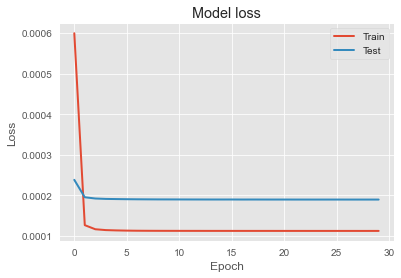

In [286]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [287]:
encoded = encoder_layer.predict(tfidf)
len(encoded[0])

25

In [288]:
decoded = decoder_layer.predict(encoded)
len(decoded[0])

359

In [289]:
with open('ml-latest-small/movie_tfidf_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded, fh)

### <font color=blue> 5. Calculate content embedding Similarity

In [290]:
path = "ml-latest-small/"

content_embeddings = pd.read_pickle(os.path.join(f'{path}movie_tfidf_embeddings.pkl'))
content_embeddings = pd.DataFrame(content_embeddings)
print(content_embeddings.shape)
content_embeddings.head()

(9125, 25)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.078,-0.078,-0.033,0.042,0.316,0.122,-0.175,0.313,0.061,0.093,-0.186,0.141,-0.179,0.106,-0.123,0.054,-0.190,0.109,0.084,-0.054,0.006,-0.017,-0.070,-0.139,0.181
1,-0.094,-0.036,0.072,0.046,0.425,0.220,-0.274,0.295,0.166,0.247,-0.082,0.039,-0.169,0.121,-0.042,-0.047,-0.116,0.034,-0.094,0.074,0.230,-0.025,-0.103,-0.327,0.198
2,0.142,0.109,0.117,-0.113,0.011,0.170,-0.182,0.480,-0.102,-0.191,-0.404,-0.094,0.066,-0.058,0.056,-0.035,-0.375,0.270,-0.099,0.231,-0.078,-0.101,0.057,0.118,0.000
3,0.051,0.180,0.053,-0.145,0.041,0.153,-0.263,0.378,0.056,-0.105,-0.429,-0.097,0.030,-0.038,0.116,0.021,-0.433,0.197,-0.060,0.212,-0.201,-0.217,0.149,0.215,0.102
4,0.042,0.098,0.020,-0.039,0.048,0.039,-0.027,0.174,-0.077,0.005,-0.083,0.012,0.004,0.002,-0.024,-0.039,-0.136,0.084,0.045,-0.075,-0.003,-0.035,0.037,-0.010,0.152


In [291]:
MovieID = 318
MovieIndex = df_movies[df_movies.movieId == MovieID].index.values[0]
print(MovieID, MovieIndex)

df_movies.loc[df_movies.movieId == MovieID,]

318 284


,movieId,title,genres,movie_rating,movie_count,tag,document,movie_index
284,318,"Shawshank Redemption, The (1994)",Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...,Crime Drama {friendship Morgan Freeman narrate...,55


#### cosine_similarity

In [292]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = pd.DataFrame(cosine_similarity(content_embeddings), index=content_embeddings.index.tolist())
result_df = df_movies.copy()
result_df['score'] = similarity_matrix.iloc[MovieIndex]
result_df = result_df[['movieId','title','score','genres','movie_rating','movie_count','tag']]
result_df.sort_values('score', ascending=False, inplace=True)
result_df.head(10)

,movieId,title,score,genres,movie_rating,movie_count,tag
284,318,"Shawshank Redemption, The (1994)",1.000,Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...
2541,3160,Magnolia (1999),0.867,Drama,3.693,57.000,{Ei muista}
857,1059,William Shakespeare's Romeo + Juliet (1996),0.833,Drama Romance,3.526,58.000,{claire daines clever Leonardo DiCaprio shakes...
1843,2329,American History X (1998),0.830,Crime Drama,4.023,107.000,{Ei muista}
695,858,"Godfather, The (1972)",0.822,Crime Drama,4.487,200.000,{Katso Sanna!}
1906,2396,Shakespeare in Love (1998),0.810,Comedy Drama Romance,3.967,121.000,{colin firth Gwenth Paltrow joseph fiennes}
3157,3949,Requiem for a Dream (2000),0.804,Drama,3.870,69.000,{Ei muista addiction psychology}
1102,1358,Sling Blade (1996),0.803,Drama,3.886,66.000,{billy bob thorton}
3213,4011,Snatch (2000),0.797,Comedy Crime Thriller,4.037,95.000,{Ei muista Guy Ritchie twist ending}
1352,1704,Good Will Hunting (1997),0.788,Drama Romance,4.140,157.000,{genius intellectual mathematics psychology}


#### Euclidean_distances

In [293]:
from sklearn.metrics.pairwise import euclidean_distances

similarity_matrix = pd.DataFrame(euclidean_distances(content_embeddings),index=content_embeddings.index.tolist())
result_df = df_movies.copy()
result_df['score'] = similarity_matrix.iloc[MovieIndex]
result_df = result_df[['movieId', 'title', 'score', 'genres', 'movie_rating', 'movie_count', 'tag']]
result_df.sort_values('score', ascending=True, inplace=True)
result_df.head()

,movieId,title,score,genres,movie_rating,movie_count,tag
284,318,"Shawshank Redemption, The (1994)",0.000,Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...
2541,3160,Magnolia (1999),0.191,Drama,3.693,57.000,{Ei muista}
3157,3949,Requiem for a Dream (2000),0.210,Drama,3.870,69.000,{Ei muista addiction psychology}
1102,1358,Sling Blade (1996),0.216,Drama,3.886,66.000,{billy bob thorton}
857,1059,William Shakespeare's Romeo + Juliet (1996),0.218,Drama Romance,3.526,58.000,{claire daines clever Leonardo DiCaprio shakes...


###  <font color=blue>6. Performance Evaluation

#### data preparation

In [415]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
df_ratings = df_ratings.reset_index(drop=True)
df_ratings.head()

M = df_ratings['movieId'].nunique()
N = df_ratings['userId'].nunique()

# saving original userId and movieId
uid = df_ratings['userId'].unique()
mid = df_ratings['movieId'].unique()

# create new userId and movieId
udx = np.arange(N)
mdx = np.arange(M)

# map ids and their indices
udx2uid = dict(zip(udx, uid))
uid2udx = dict(zip(uid, udx))
mdx2mid = dict(zip(mdx, mid))
mid2mdx = dict(zip(mid, mdx))

# apply index to dataframe
df_ratings['user_index'] = df_ratings.apply(lambda x:uid2udx[x['userId']], axis=1)
df_ratings['movie_index'] = df_ratings.apply(lambda x:mid2mdx[x['movieId']], axis=1)

df_movies = df_movies[df_movies.movieId.isin(mid2mdx.keys())]
df_movies['movie_index'] = df_movies.apply(lambda x:mid2mdx[x['movieId']], axis=1)

In [416]:
MovieID = 318
MovieIndex = mid2mdx[MovieID]
print(MovieID, MovieIndex)

df_movies.loc[df_movies.movieId == MovieID,]

318 55


,movieId,title,genres,movie_index
284,318,"Shawshank Redemption, The (1994)",Crime|Drama,55


In [417]:
path = "ml-latest-small/"

content_embeddings = pd.read_pickle(os.path.join(f'{path}movie_tfidf_embeddings.pkl'))
content_embeddings = pd.DataFrame(content_embeddings)
print(content_embeddings.shape)
content_embeddings.head()

(9125, 25)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.078,-0.078,-0.033,0.042,0.316,0.122,-0.175,0.313,0.061,0.093,-0.186,0.141,-0.179,0.106,-0.123,0.054,-0.190,0.109,0.084,-0.054,0.006,-0.017,-0.070,-0.139,0.181
1,-0.094,-0.036,0.072,0.046,0.425,0.220,-0.274,0.295,0.166,0.247,-0.082,0.039,-0.169,0.121,-0.042,-0.047,-0.116,0.034,-0.094,0.074,0.230,-0.025,-0.103,-0.327,0.198
2,0.142,0.109,0.117,-0.113,0.011,0.170,-0.182,0.480,-0.102,-0.191,-0.404,-0.094,0.066,-0.058,0.056,-0.035,-0.375,0.270,-0.099,0.231,-0.078,-0.101,0.057,0.118,0.000
3,0.051,0.180,0.053,-0.145,0.041,0.153,-0.263,0.378,0.056,-0.105,-0.429,-0.097,0.030,-0.038,0.116,0.021,-0.433,0.197,-0.060,0.212,-0.201,-0.217,0.149,0.215,0.102
4,0.042,0.098,0.020,-0.039,0.048,0.039,-0.027,0.174,-0.077,0.005,-0.083,0.012,0.004,0.002,-0.024,-0.039,-0.136,0.084,0.045,-0.075,-0.003,-0.035,0.037,-0.010,0.152


In [418]:
content_embeddings_cols = content_embeddings.columns
content_embeddings['movieId'] = df_movies['movieId']
content_embeddings = content_embeddings[content_embeddings.movieId.isin(mid2mdx.keys())]
content_embeddings['movie_index'] = content_embeddings.apply(lambda x:mid2mdx[x['movieId']], axis=1)
content_embeddings = content_embeddings.sort_values(['movie_index'])

print(content_embeddings.shape)
content_embeddings[content_embeddings.movieId == MovieID]

(444, 27)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,movieId,movie_index
284,0.069,0.052,0.104,-0.052,0.026,0.085,-0.073,0.085,-0.049,0.006,-0.007,-0.064,-0.046,0.010,0.048,-0.012,-0.159,0.038,0.058,-0.106,0.062,-0.006,0.072,0.041,0.130,318.000,55


#### Recommendations

In [419]:
def get_detailed_recs(movie_index, embeddings, df_movies):
    #get similar movies
    similarity_matrix = cosine_similarity(embeddings)
    item_sim_df = pd.DataFrame(similarity_matrix[movie_index])
    item_sim_df =  item_sim_df.reset_index(drop=False)
    item_sim_df.columns = ['movie_index', 'similarity_score']
    # assign movie_index
    item_sim_df['movie_index'] = sorted(mdx2mid.keys())
    # merge with table item_data to get the description info
    item_sim_df = item_sim_df.merge(df_movies, left_on='movie_index', right_on = 'movie_index', how='left')
    # sort similarity score in descending order
    item_sim_df = item_sim_df.sort_values('similarity_score', ascending=False)
    item_sim_df.reset_index(drop=True, inplace=True)  

    return item_sim_df

In [420]:
CT_sim_df = get_detailed_recs(MovieIndex, content_embeddings[content_embeddings_cols], df_movies)
CT_sim_df.head(10)

,movie_index,similarity_score,movieId,title,genres
0,55,1.000,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,368,0.867,3160,Magnolia (1999),Drama
2,304,0.833,1059,William Shakespeare's Romeo + Juliet (1996),Drama|Romance
3,234,0.830,2329,American History X (1998),Crime|Drama
4,90,0.822,858,"Godfather, The (1972)",Crime|Drama
5,351,0.810,2396,Shakespeare in Love (1998),Comedy|Drama|Romance
6,68,0.804,3949,Requiem for a Dream (2000),Drama
7,226,0.803,1358,Sling Blade (1996),Drama
8,240,0.797,4011,Snatch (2000),Comedy|Crime|Thriller
9,231,0.788,1704,Good Will Hunting (1997),Drama|Romance


####  <font color=blue>Split data

The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings. 
Since we have split the data into testing and training we will need to create two matrices (all users by all movies). 

In [421]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn

train_data, test_data = train_test_split(df_ratings[['user_index', 'movie_index', 'rating']], test_size=0.2)

# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((N, M))
for line in train_data.itertuples():
    train_data_matrix[line[1], line[2]] = line[3]
    
test_data_matrix = np.zeros((N, M))
for line in test_data.itertuples():
    test_data_matrix[line[1], line[2]] = line[3]
    
train_data_matrix.shape, test_data_matrix.shape

((427, 444), (427, 444))

In [422]:
from sklearn.metrics import mean_squared_error
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    '''
    print('prediction:')
    print(pred[0:10])
    print('actual:')
    print(actual[0:10])
    '''
    return sqrt(mean_squared_error(pred, actual))

In [454]:
from sklearn.neighbors import NearestNeighbors

k = 20
item_pred_k = np.zeros(train_data_matrix.T.shape)
knn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
knn_item.fit(content_embeddings[content_embeddings_cols])
# user item matrix is train_data_matrix, item user matrix is train_data_matrix.T
top_k_distances, top_k_movies = knn_item.kneighbors(content_embeddings[content_embeddings_cols], return_distance=True)
top_k_distances = np.round(1 - top_k_distances,3)

for i in range(train_data_matrix.T.shape[0]):
    item_pred_k[i,:] = top_k_distances[i].dot(train_data_matrix.T[top_k_movies][i])/np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T
    
print('Train set')
print(rmse(item_pred_k, train_data_matrix.T))
print('\n\nTest set')
print(rmse(item_pred_k, test_data_matrix.T))

Train set
2.736940455632112


Test set
2.9677376756601173


### <font color=blue> 8. Analyzing the Results and Conclusion

#### Advantages
+ User independence: Collaborative filtering needs other users’ ratings to find similarities between the users and then give suggestions. Instead, the content-based method only has to analyze the items and a single user’s profile for the recommendation, which makes the process less cumbersome. Content-based filtering would thus produce more reliable results with fewer users in the system.
+ Transparency: Collaborative filtering gives recommendations based on other unknown users who have the same taste as a given user, but with content-based filtering items are recommended on a feature-level basis.
+ No cold start: As opposed to collaborative filtering, new items can be suggested before being rated by a substantial number of users.

#### Disadvantages
+ Limited content analysis: If the content doesn’t contain enough information to discriminate the items precisely, the recommendation itself risks being imprecise.
+ Over-specialization: Content-based filtering provides a limited degree of novelty, since it has to match up the features of a user’s profile with available items. In the case of item-based filtering, only item profiles are created and users are suggested items similar to what they rate or search for, instead of their past history. A perfect content-based filtering system may suggest nothing unexpected or surprising.

#### Conclusion
We have learned to make a fully-functional recommender system in Python with content-based filtering. But as we saw above, content-based filtering is not practical, or rather, not very dependable when the number of items increases along with a need for clear and differentiated descriptions

To overcome all the issues discussed earlier, we can implement collaborative filtering techniques, which have proven to be better and more scalable. We’ll work on their implementations in the upcoming parts of the series.

##  <font color=red>6.2. Product Profile and User Profile</font>

### <font color=blue> 1. Data Preparation

In [210]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
print(df_ratings.shape)
df_ratings.head()

(38133, 4)


,userId,movieId,rating,timestamp
0,2,10,4.000,835355493
1,2,17,5.000,835355681
2,2,39,5.000,835355604
3,2,47,4.000,835355552
4,2,50,4.000,835355586


#### Map user_index and movie_index

In [211]:
df_ratings = df_ratings.reset_index(drop=True)
df_ratings.head()

M = df_ratings['movieId'].nunique()
N = df_ratings['userId'].nunique()

# saving original userId and movieId
uid = df_ratings['userId'].unique()
mid = df_ratings['movieId'].unique()

# create new userId and movieId
udx = np.arange(N)
mdx = np.arange(M)

# map ids and their indices
udx2uid = dict(zip(udx, uid))
uid2udx = dict(zip(uid, udx))
mdx2mid = dict(zip(mdx, mid))
mid2mdx = dict(zip(mid, mdx))

# apply index to dataframe
df_ratings['user_index'] = df_ratings.apply(lambda x:uid2udx[x['userId']], axis=1)
df_ratings['movie_index'] = df_ratings.apply(lambda x:mid2mdx[x['movieId']], axis=1)

df_ratings.head()

,userId,movieId,rating,timestamp,user_index,movie_index
0,2,10,4.000,835355493,0,0
1,2,17,5.000,835355681,0,1
2,2,39,5.000,835355604,0,2
3,2,47,4.000,835355552,0,3
4,2,50,4.000,835355586,0,4


In [212]:
movie_profile.head()

,movieId,title,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war
0,1,Toy Story (1995),3.872,247.000,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0
1,2,Jumanji (1995),3.402,107.000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),3.161,59.000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale (1995),2.385,13.000,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,5,Father of the Bride Part II (1995),3.268,56.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [65]:
item_prof = movie_profile.copy()
item_prof = item_prof[item_prof.movieId.isin(mid2mdx.keys())]
item_prof = item_prof.drop(['movieId','title'],axis=1).values
print(item_prof.shape)

(444, 18)


In [66]:
item_prof

array([[  3.87246964, 247.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  3.40186916, 107.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  3.16101695,  59.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  3.64179104,  67.        ,   1.        , ...,   1.        ,
          0.        ,   0.        ],
       [  3.79411765,  51.        ,   0.        , ...,   0.        ,
          1.        ,   0.        ],
       [  4.04954955, 111.        ,   1.        , ...,   1.        ,
          1.        ,   0.        ]])

In [67]:
user_item_mt = df_ratings.pivot_table(index='user_index', columns='movie_index', values='rating')
user_item_mt.fillna(0, inplace=True)
print(user_item_mt.shape)
user_item_mt.head(2)

(427, 444)


movie_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.000,5.000,5.000,4.000,4.000,3.000,3.000,4.000,5.000,4.000,3.000,3.000,3.000,3.000,1.000,3.000,3.000,4.000,4.000,5.000,5.000,3.000,4.000,3.000,2.000,3.000,4.000,4.000,3.000,3.000,3.000,3.000,2.000,3.000,3.000,4.000,3.000,2.000,4.000,3.000,3.000,4.000,4.000,4.000,4.000,3.000,5.000,3.000,3.000,3.000,5.000,5.000,5.000,3.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

In [68]:
ratmat = user_item_mt.values

In [69]:
#dot product
from scipy import linalg, dot
user_prof = dot(ratmat,item_prof)/linalg.norm(ratmat)/linalg.norm(item_prof)

print(user_prof.shape)
user_prof

(427, 18)


array([[4.03145936e-04, 1.28009112e-02, 3.31373786e-05, ...,
        1.51152955e-05, 3.48814512e-05, 4.65086016e-06],
       [2.12201648e-04, 7.88844019e-03, 2.47076946e-05, ...,
        2.03475132e-06, 2.09288707e-05, 2.03475132e-06],
       [1.02607286e-03, 3.06032412e-02, 7.73205502e-05, ...,
        3.54628087e-05, 8.37154829e-05, 1.68593681e-05],
       ...,
       [1.28323264e-03, 3.42227731e-02, 9.24358457e-05, ...,
        7.38324050e-05, 9.01104156e-05, 2.20915858e-05],
       [3.50729799e-04, 1.01272480e-02, 3.13933061e-05, ...,
        1.51152955e-05, 1.97661557e-05, 3.48814512e-06],
       [8.10724654e-04, 2.20552509e-02, 6.36586484e-05, ...,
        4.36018140e-05, 6.16238971e-05, 1.16271504e-05]])

In [70]:
user_prof.shape, item_prof.shape

((427, 18), (444, 18))

In [71]:
#cosine similarity between  userprofile an item profile
import sklearn.metrics
similarityCalc = sklearn.metrics.pairwise.cosine_similarity(user_prof, item_prof, dense_output=True)
#covert the rating to binary format
final_pred= np.where(similarityCalc>0.6, 1, 0)
indexes_of_user = np.where(final_pred[213] == 1)

In [72]:
similarityCalc

array([[0.99983397, 0.99987253, 0.99952677, ..., 0.99946438, 0.99862764,
        0.99983717],
       [0.99990057, 0.99986345, 0.99942988, ..., 0.99934409, 0.99839696,
        0.99978732],
       [0.99981014, 0.99988815, 0.9995856 , ..., 0.99950904, 0.99869613,
        0.99983041],
       ...,
       [0.99972208, 0.99986429, 0.99964097, ..., 0.99960283, 0.99887062,
        0.99985381],
       [0.99978155, 0.99987517, 0.99960143, ..., 0.99955411, 0.99873312,
        0.99984211],
       [0.99973761, 0.99986396, 0.99963219, ..., 0.99958737, 0.99884051,
        0.99985119]])

---

# <div class="alert alert-info"> 7. CF-KNN based recommender system </div>

## <font color=red>7.1. Data Preparation</font> 

###  <font color=blue>1. Map user_index and movie_index

In [213]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
print(df_ratings.shape)
df_ratings = df_ratings.reset_index(drop=True)
df_ratings.head()

M = df_ratings['movieId'].nunique()
N = df_ratings['userId'].nunique()

# saving original userId and movieId
uid = df_ratings['userId'].unique()
mid = df_ratings['movieId'].unique()

# create new userId and movieId
udx = np.arange(N)
mdx = np.arange(M)

# map ids and their indices
udx2uid = dict(zip(udx, uid))
uid2udx = dict(zip(uid, udx))
mdx2mid = dict(zip(mdx, mid))
mid2mdx = dict(zip(mid, mdx))

# apply index to dataframe
df_ratings['user_index'] = df_ratings.apply(lambda x:uid2udx[x['userId']], axis=1)
df_ratings['movie_index'] = df_ratings.apply(lambda x:mid2mdx[x['movieId']], axis=1)

df_ratings.head()

(38133, 4)


,userId,movieId,rating,timestamp,user_index,movie_index
0,2,10,4.000,835355493,0,0
1,2,17,5.000,835355681,0,1
2,2,39,5.000,835355604,0,2
3,2,47,4.000,835355552,0,3
4,2,50,4.000,835355586,0,4


###  <font color=blue> 2. Calculate User Item Matrix and Item User Matrix

#### User Item matrix

In [214]:
user_item_mt = df_ratings.pivot_table(index='user_index', columns='movie_index', values='rating')
user_item_mt.fillna(0, inplace=True)
user_item_mt.head(2)

movie_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.000,5.000,5.000,4.000,4.000,3.000,3.000,4.000,5.000,4.000,3.000,3.000,3.000,3.000,1.000,3.000,3.000,4.000,4.000,5.000,5.000,3.000,4.000,3.000,2.000,3.000,4.000,4.000,3.000,3.000,3.000,3.000,2.000,3.000,3.000,4.000,3.000,2.000,4.000,3.000,3.000,4.000,4.000,4.000,4.000,3.000,5.000,3.000,3.000,3.000,5.000,5.000,5.000,3.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

#### Item User matrix

In [215]:
#item_user_mt = user_item_mt.T

item_user_mt = df_ratings.pivot_table(index='movie_index', columns='user_index', values='rating')
item_user_mt.fillna(0, inplace=True)
item_user_mt.head(2)

user_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426
movie_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.000,0.000,4.000,0.000,3.000,0.000,0.000,0.000,3.000,0.000,0.000,3.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.000,5.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,4.000,3.500,0.000,0.000,0.000,0.000,3.000,0.000,0.000,3.000,0.000,3.500,0.000,0.000,4.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,5.000,1.500,0.000,0.000,3.500,2.500,0.000,4.000,0.000,4.000,2.500,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.500,0.000,0.000,0.000,3.500,0.000,3.500,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,0.000,4.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.000,0.000,0.000,4.000,0.000,3.000,4.500,0.000,4.000,0.000,3.500,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,1.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,3.000,0.000,0.000,2.000,4.000,3.000,0.000,0.000,0.000,3.000,0.000,0.000,3.000,0.000,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,2.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.500,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,2.000,4.000,0.000,2.000,0.000,0.000,0.000,0.000,3.000,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

###  <font color=blue>3. Split data

The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings. 
Since we have split the data into testing and training we will need to create two matrices (all users by all movies). 

In [216]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn

train_data, test_data = train_test_split(df_ratings[['user_index', 'movie_index', 'rating']], test_size=0.2)

# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((N, M))
for line in train_data.itertuples():
    train_data_matrix[line[1], line[2]] = line[3]
    
test_data_matrix = np.zeros((N, M))
for line in test_data.itertuples():
    test_data_matrix[line[1], line[2]] = line[3]
    
train_data_matrix.shape, test_data_matrix.shape

((427, 444), (427, 444))

##  <font color=red>7.2. Memory-based CF: Item-Item CF</font>

###  <font color=blue>1. Calculate user similarity and item similarity using cosine

In [217]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1 - pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')

user_similarity.shape, item_similarity.shape

((427, 427), (444, 444))

In [218]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(train_data_matrix)
item_similarity = cosine_similarity(train_data_matrix.T)

pd.DataFrame(user_similarity).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426
0,1.000,0.153,0.129,0.138,0.219,0.121,0.038,0.202,0.234,0.086,0.064,0.334,0.134,0.211,0.150,0.186,0.134,0.000,0.272,0.029,0.000,0.168,0.440,0.190,0.311,0.099,0.242,0.218,0.066,0.077,0.032,0.133,0.148,0.083,0.159,0.025,0.070,0.000,0.033,0.409,0.164,0.117,0.089,0.077,0.216,0.118,0.176,0.210,0.144,0.024,0.130,0.090,0.487,0.520,0.247,0.162,0.027,0.103,0.456,0.233,0.164,0.118,0.030,0.063,0.074,0.209,0.068,0.113,0.053,0.107,0.233,0.511,0.230,0.082,0.146,0.170,0.200,0.504,0.176,0.116,0.451,0.271,0.146,0.076,0.102,0.194,0.066,0.124,0.078,0.077,0.072,0.134,0.151,0.096,0.104,0.168,0.627,0.192,0.023,0.116,0.132,0.263,0.154,0.614,0.223,0.073,0.261,0.053,0.387,0.000,0.100,0.056,0.263,0.074,0.468,0.155,0.160,0.559,0.020,0.009,0.439,0.021,0.475,0.184,0.137,0.033,0.000,0.105,0.122,0.218,0.035,0.120,0.126,0.293,0.191,0.198,0.124,0.041,0.064,0.193,0.150,0.000,0.265,0.049,0.025,0.264,0.057,0.199,0.114,0.056,0.106,0.236,0.372,0.185,0.169,0.124,0.118,0.216,0.132,0.044,0.118,0.158,0.342,0.032,0.042,0.166,0.184,0.162,0.024,0.208,0.053,0.108,0.049,0.113,0.108,0.052,0.600,0.248,0.233,0.187,0.012,0.225,0.081,0.489,0.062,0.067,0.264,0.045,0.262,0.219,0.055,0.000,0.066,0.135,0.098,0.332,0.087,0.432,0.015,0.335,0.310,0.265,0.015,0.025,0.000,0.088,0.077,0.189,0.120,0.130,0.250,0.106,0.568,0.135,0.118,0.430,0.144,0.076,0.032,0.015,0.088,0.198,0.351,0.252,0.164,0.036,0.049,0.132,0.068,0.063,0.638,0.071,0.139,0.110,0.042,0.054,0.132,0.119,0.093,0.168,0.202,0.181,0.601,0.068,0.038,0.202,0.298,0.274,0.210,0.014,0.183,0.426,0.000,0.000,0.564,0.023,0.115,0.150,0.028,0.148,0.174,0.356,0.127,0.077,0.380,0.108,0.220,0.073,0.029,0.178,0.047,0.069,0.136,0.000,0.106,0.200,0.138,0.102,0.090,0.167,0.000,0.096,0.117,0.263,0.415,0.043,0.038,0.262,0.100,0.050,0.186,0.157,0.043,0.237,0.082,0.211,0.190,0.005,0.204,0.127,0.174,0.159,0.129,0.082,0.045,0.057,0.220,0.042,0.000,0.094,0.037,0.570,0.038,0.182,0.151,0.185,0.070,0.439,0.034,0.111,0.069,0.098,0.179,0.209,0.091,0.308,0.371,0.236,0.056,0.112,0.108,0.227,0.024,0.084,0.145,0.056,0.126,0.163,0.118,0.124,0.095,0.352,0.542,0.401,0.250,0.000,0.096,0.144,0.025,0.226,0.369,0.171,0.242,0.047,0.076,0.322,0.036,0.000,0.170,0.126,0.165,0.234,0.085,0.291,0.074,0.157,0.059,0.087,0.129,0.107,0.272,0.196,0.120,0.131,0.140,0.124,0.132,0.421,0.529,0.150,0.395,0.096,0.229,0.288,0.104,0.132,0.079,0.465,0.243,0.167,0.079,0.182,0.155,0.018,0.000,0.056,0.000,0.139,0.111,0.244

###  <font color=blue>2. Prediction using all data

Next step is to make predictions. You have already created similarity matrices: `user_similarity` and `item_similarity` and therefore you can make a prediction by applying following formula for user-based CF and item-based CF

In [219]:
item_pred = item_similarity.dot(train_data_matrix.T)/np.array([np.abs(item_similarity).sum(axis=1)]).T
print(item_pred.shape)

(444, 427)


###  <font color=blue>3.  Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is *Root Mean Squared Error (RMSE)*. 
<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

You can use the [mean_square_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE) function from `sklearn`, where the RMSE is just the square root of MSE. To read more about different evaluation metrics you can take a look at [this article](http://research.microsoft.com/pubs/115396/EvaluationMetrics.TR.pdf). 

Since you only want to consider predicted ratings that are in the test dataset, you filter out all other elements in the prediction matrix with `prediction[ground_truth.nonzero()]`. 

In [220]:
from sklearn.metrics import mean_squared_error
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    print('prediction:')
    print(pred[0:10])
    print('actual:')
    print(actual[0:10])
    return sqrt(mean_squared_error(pred, actual))

In [221]:
print('Train set')
print(rmse(item_pred, train_data_matrix.T))
print('\n\nTest set')
print(rmse(item_pred, test_data_matrix.T))

Train set
prediction:
[0.56680761 1.26016584 0.70707441 0.4345355  1.15497423 2.41597091
 1.36405761 1.38619349 0.73575542 0.87074858]
actual:
[4. 3. 3. 5. 4. 3. 3. 5. 5. 4.]
2.869169431132059


Test set
prediction:
[0.95792918 0.44071615 2.07164127 0.78688811 1.51352362 1.62959087
 0.451348   0.9826166  0.7386042  0.35025038]
actual:
[4.  3.  3.  2.  3.5 4.  4.  4.  4.  3. ]
2.9355792593278593


###  <font color=blue>4. Prediction using k neigbors

The k-nearest neighbors (KNN) algorithm doesn’t make any assumptions on the underlying data distribution, but it relies on item feature similarity. When a KNN makes a prediction about a movie, it will calculate the “distance” (distance metrics will be discussed later) between the target movie and every other movie in its database. It then ranks its distances and returns the top k nearest neighbor movies as the most similar movie recommendations.

In [222]:
train_data_matrix.T

array([[4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 2. , 0. ],
       [5. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 3. , 0. , 2.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [223]:
from sklearn.neighbors import NearestNeighbors

k = 15
item_pred_k = np.zeros(train_data_matrix.T.shape)
knn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
knn_item.fit(train_data_matrix.T)
# user item matrix is train_data_matrix, item user matrix is train_data_matrix.T
top_k_distances, top_k_movies = knn_item.kneighbors(train_data_matrix.T, return_distance=True)
top_k_distances = np.round(1 - top_k_distances,3)

for i in range(train_data_matrix.T.shape[0]):
    item_pred_k[i,:] = top_k_distances[i].dot(train_data_matrix.T[top_k_movies][i])/np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T
    
print('Train set')
print(rmse(item_pred_k, train_data_matrix.T))
print('\n\nTest set')
print(rmse(item_pred_k, test_data_matrix.T))

Train set
prediction:
[3.01710026 2.83762058 1.62160187 2.43232973 1.61005554 2.70191464
 2.28076586 2.30276235 4.08228588 3.82943584]
actual:
[4. 3. 3. 5. 4. 3. 3. 5. 5. 4.]
1.845699820018858


Test set
prediction:
[1.22420345 1.47895352 2.54348144 2.20651856 2.01322713 1.86064016
 0.84039754 1.91727565 2.62569424 0.49342298]
actual:
[4.  3.  3.  2.  3.5 4.  4.  4.  4.  3. ]
2.563560230942129


###  <font color=blue>5. Recommendation

In [224]:
MovieID = 318
MovieIndex = mid2mdx[MovieID]
print(MovieID, MovieIndex)

318 55


#### Find similar movies

In [225]:
print("Most similar movies of movie: ", df_movies[df_movies.movieId == MovieID].title.iloc[0])

item_sim_df = pd.DataFrame(item_similarity[MovieIndex])
item_sim_df =  item_sim_df.reset_index(drop=False)
item_sim_df.columns = ['movie_index', 'similarity_score']
# assign movie_index
item_sim_df['movie_index'] = sorted(mdx2mid.keys())
# map ItemIndex to ItemID
item_sim_df['movieId'] = item_sim_df['movie_index'].apply(lambda x:mdx2mid[x])
# merge with table item_data to get the description info
item_sim_df = item_sim_df.merge(df_movies, on='movieId', how='left')
# sort similarity score in descending order
item_sim_df = item_sim_df.sort_values('similarity_score', ascending=False)
item_sim_df.reset_index(drop=True, inplace=True)
item_sim_df.loc[1:5]

Most similar movies of movie:  Shawshank Redemption, The (1994)


,movie_index,similarity_score,movieId,title,genres,movie_rating,movie_count,tag,document
1,28,0.584,356,Forrest Gump (1994),Comedy Drama Romance War,4.054,341.000,{},Comedy Drama Romance War {}
2,22,0.568,296,Pulp Fiction (1994),Comedy Crime Drama Thriller,4.256,324.000,{intense r:violence tarantino dark comedy Quen...,Comedy Crime Drama Thriller {intense r:violenc...
3,44,0.555,527,Schindler's List (1993),Drama War,4.303,244.000,{},Drama War {}
4,53,0.551,593,"Silence of the Lambs, The (1991)",Crime Horror Thriller,4.138,304.000,{Katso Sanna!},Crime Horror Thriller {Katso Sanna!}
5,36,0.514,457,"Fugitive, The (1993)",Thriller,3.953,213.000,{},Thriller {}


In [226]:
def item(item_id):
    return df_movies.loc[df_movies['movieId'] == item_id].title.values[0]

def cf_item_recommendation(item_similarity, item_id, num, ascending_type):
    print("Recommending " + str(num) + " movies similar to " + item(item_id) + "...")
    print("----------")
    result_df = df_movies.copy()
    result_df = result_df[result_df.movieId.isin(mid2mdx.keys())].reset_index(drop=True) 
    result_df['movie_index'] = result_df.apply(lambda x:mid2mdx[x['movieId']], axis=1)
    result_df = result_df.sort_values(['movie_index'],ascending=True)
    result_df = result_df.reset_index(drop=True)
    result_df['score'] = item_similarity.iloc[MovieIndex]
    result_df = result_df[['movieId','title','score','genres','movie_rating','movie_count','tag']]
    result_df.sort_values('score', ascending=ascending_type, inplace=True) 
    result_df.reset_index(drop=True, inplace=True)
    result_df = result_df.loc[1: 5]
    
    return result_df

item_similarity_df = pd.DataFrame(item_similarity)
content_recommendation_df = cf_item_recommendation(item_similarity_df, MovieID, 5, False)
content_recommendation_df

Recommending 5 movies similar to Shawshank Redemption, The (1994)...
----------


,movieId,title,score,genres,movie_rating,movie_count,tag
1,356,Forrest Gump (1994),0.584,Comedy Drama Romance War,4.054,341.000,{}
2,296,Pulp Fiction (1994),0.568,Comedy Crime Drama Thriller,4.256,324.000,{intense r:violence tarantino dark comedy Quen...
3,527,Schindler's List (1993),0.555,Drama War,4.303,244.000,{}
4,593,"Silence of the Lambs, The (1991)",0.551,Crime Horror Thriller,4.138,304.000,{Katso Sanna!}
5,457,"Fugitive, The (1993)",0.514,Thriller,3.953,213.000,{}


###  <font color=blue>6. Calculate similarity using euclidean distance

In [227]:
from sklearn.metrics.pairwise import euclidean_distances

user_similarity = euclidean_distances(train_data_matrix)
item_similarity = euclidean_distances(train_data_matrix.T)

pd.DataFrame(user_similarity).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426
0,0.000,28.381,47.571,36.572,30.545,39.541,27.423,28.111,56.071,45.511,29.766,42.119,30.261,36.304,41.860,55.243,37.084,32.265,59.161,34.914,32.619,38.613,24.576,31.488,27.148,38.852,32.442,29.883,44.331,30.968,29.741,47.990,42.650,26.683,32.909,34.121,37.470,29.921,40.311,27.185,36.083,38.161,32.680,38.230,62.416,37.690,45.395,48.417,26.847,31.690,39.821,33.645,26.702,25.962,45.492,36.586,30.033,37.145,28.983,40.847,40.811,41.845,30.553,34.803,31.492,37.443,33.444,52.374,34.391,31.548,47.911,29.309,43.806,27.564,41.097,53.796,37.443,25.159,35.896,51.575,25.632,42.673,48.335,29.176,29.296,53.341,32.573,34.264,32.234,33.534,27.368,32.350,33.358,38.917,37.179,46.193,23.833,40.423,31.984,31.273,41.554,36.575,32.634,24.228,29.219,35.948,44.162,30.814,28.810,35.944,36.579,36.932,40.853,37.550,28.723,41.677,42.550,26.058,34.366,30.871,25.000,33.347,24.536,41.797,27.982,32.818,34.886,44.472,38.487,39.598,30.512,34.850,29.900,54.266,40.691,43.174,30.545,40.321,38.039,38.210,42.919,27.074,29.257,34.084,38.288,52.716,37.670,43.006,36.242,29.996,40.768,42.752,25.120,55.435,46.081,31.650,39.535,42.214,35.567,38.477,34.398,46.311,29.799,34.558,30.773,30.025,37.597,31.480,35.833,56.588,37.051,36.466,37.206,43.526,29.787,29.292,21.679,31.718,36.932,37.733,30.000,46.163,42.471,27.331,31.965,36.373,48.226,32.249,51.269,48.133,34.814,32.596,36.538,47.553,35.160,49.406,33.679,24.021,43.347,47.143,37.216,42.881,27.839,37.202,28.583,31.032,28.896,34.569,31.828,34.695,26.926,32.806,21.932,32.384,41.665,33.823,47.302,40.423,28.740,40.915,32.241,41.030,26.926,49.056,50.498,30.100,39.693,38.794,31.879,38.295,20.494,38.308,34.139,38.962,30.627,34.478,32.981,56.569,31.890,36.311,28.443,45.918,25.100,31.686,42.178,59.445,25.884,34.511,28.496,28.605,38.455,28.160,26.674,31.859,23.108,36.152,37.064,43.000,31.036,43.217,38.717,24.779,34.059,26.192,27.055,36.517,34.601,30.397,36.973,33.437,45.117,32.837,40.660,36.586,45.003,52.697,50.520,36.633,46.901,38.897,31.464,38.820,33.808,47.347,26.038,42.878,27.964,55.491,32.357,33.934,42.641,33.038,46.979,54.424,31.452,52.144,42.166,29.257,49.850,25.952,36.449,59.233,32.958,43.881,35.046,35.039,50.564,49.338,28.196,37.253,36.766,25.534,29.597,28.478,25.259,29.933,35.292,30.315,33.556,36.215,41.422,38.328,40.568,56.033,33.675,44.136,30.348,52.877,40.789,41.289,36.783,40.330,31.544,40.447,36.228,35.465,44.020,32.726,34.194,30.765,34.655,36.510,22.672

In [228]:
item_similarity_df = pd.DataFrame(item_similarity)
content_recommendation_df = cf_item_recommendation(item_similarity_df, MovieID, 5, True)
content_recommendation_df

Recommending 5 movies similar to Shawshank Redemption, The (1994)...
----------


,movieId,title,score,genres,movie_rating,movie_count,tag
1,457,"Fugitive, The (1993)",56.633,Thriller,3.953,213.000,{}
2,356,Forrest Gump (1994),56.683,Comedy Drama Romance War,4.054,341.000,{}
3,3147,"Green Mile, The (1999)",56.950,Crime Drama,3.922,103.000,{}
4,590,Dances with Wolves (1990),57.013,Adventure Drama Western,3.718,202.000,{}
5,597,Pretty Woman (1990),57.252,Comedy Romance,3.361,147.000,{}


##  <font color=red>**7.3. Neighbor User CF**</font>

###  <font color=blue>1. Prediction using all data

Next step is to make predictions. You have already created similarity matrices: `user_similarity` and `item_similarity` and therefore you can make a prediction by applying following formula for user-based CF and item-based CF

In [229]:
user_pred = user_similarity.dot(train_data_matrix)/np.array([np.abs(user_similarity).sum(axis=1)]).T
user_pred.shape

(427, 444)

###  <font color=blue>2.  Evaluation

In [230]:
print(rmse(user_pred, train_data_matrix))
print(rmse(user_pred, test_data_matrix))

prediction:
[0.52403912 0.44811741 0.76726685 1.4388699  0.2911571  1.52062229
 1.32945775 0.54376523 0.43999883 0.78226799]
actual:
[4. 5. 5. 4. 3. 4. 5. 4. 3. 3.]
3.1053249897265354
prediction:
[1.46055117 0.47761226 0.36880552 0.52998426 0.34319301 0.40104234
 0.66599218 0.97729235 1.97874543 1.33326107]
actual:
[4. 3. 3. 3. 3. 3. 5. 5. 3. 3.]
3.103057340175867


###  <font color=blue>3. Apply KNN

In [231]:
k=12

from sklearn.neighbors import NearestNeighbors
#neigh = NearestNeighbors(k,'cosine')
neigh = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)

neigh.fit(train_data_matrix)
top_k_distances,top_k_users = neigh.kneighbors(train_data_matrix, return_distance=True)
top_k_distances = 1 - top_k_distances

top_k_distances.shape
top_k_users.shape, top_k_distances.shape

((427, 12), (427, 12))

In [232]:
top_k_distances.shape

(427, 12)

In [233]:
user_pred_k = np.zeros(train_data_matrix.shape)

for i in range(train_data_matrix.shape[0]):
    user_pred_k[i,:] =   top_k_distances[i].T.dot(train_data_matrix[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T
user_pred_k.shape
user_pred_k
print(rmse(user_pred_k, train_data_matrix))
print(rmse(user_pred_k, test_data_matrix))

prediction:
[2.03124121 2.01556178 2.8115499  2.32577946 0.40322752 2.04777454
 3.05787167 2.19969856 2.03029534 2.63375419]
actual:
[4. 5. 5. 4. 3. 4. 5. 4. 3. 3.]
1.6219037903651286
prediction:
[1.44329788 0.33037381 1.26284065 1.35384168 1.26804719 0.
 0.44835637 1.83081191 2.17699233 0.78843678]
actual:
[4. 3. 3. 3. 3. 3. 5. 5. 3. 3.]
2.4449938794344135


##  <font color=red>7.5. Discussion

Memory-based algorithms are easy to implement and produce reasonable prediction quality. 
The drawback of memory-based CF is that it doesn't scale to real-world scenarios and doesn't address the well-known cold-start problem, that is when new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system. I would like to thank Ethan Rosenthal for his [post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) about Memory-Based Collaborative Filtering. 

---
---
# <div class="alert alert-info"> 8. Matrix Factorization-based Recommendation Engine</div>

## <font color=red>**8.1 Overview**</font>

### <font color=blue>1. Introduction </font>
1. Matrix factorization refers to identification of two or more matrices from an initial matrix, such that these matrices are multiplied we get the original matrix. 
2. Matrix factorization can be used to discover latent features between two diffent kinds of entities. In Recommder System, the goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings to then predict the unknown ratings through the dot product of the latent leatures of users and items.
3. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF.

### <font color=blue>2. Latent variables</font>

Consider the MovieLens dataset as an example of the learned latent preferences of the users and items: 
+ you have the following inforamtion: (user_id, age, location, gender, movie_id, director, actor, language, year, rating).
+ By applying matrix factorization the model learns that important user features are age group (under 10, 10-18, 18-30, 30-60), location and gender, and for movie features it learns that decade, director and actor are most important.  
+ Now if you look into the informatin you have stored, there is no such features, but the model can learn on its own. The important aspect is that the CF model only uses data (user_id, movie_id, rating) to learn the latent features. 
+ If there is little data available CF-based model will predict poorly, since it will be more difficult to learn the latent features.

### <font color=blue>3. Utitlity matrix</font>

The starting point of any matix factorization-based method is the utility matrix. The utility matrix is a matrix of user x item dimension in which each row represents a user and each columns stands for an item

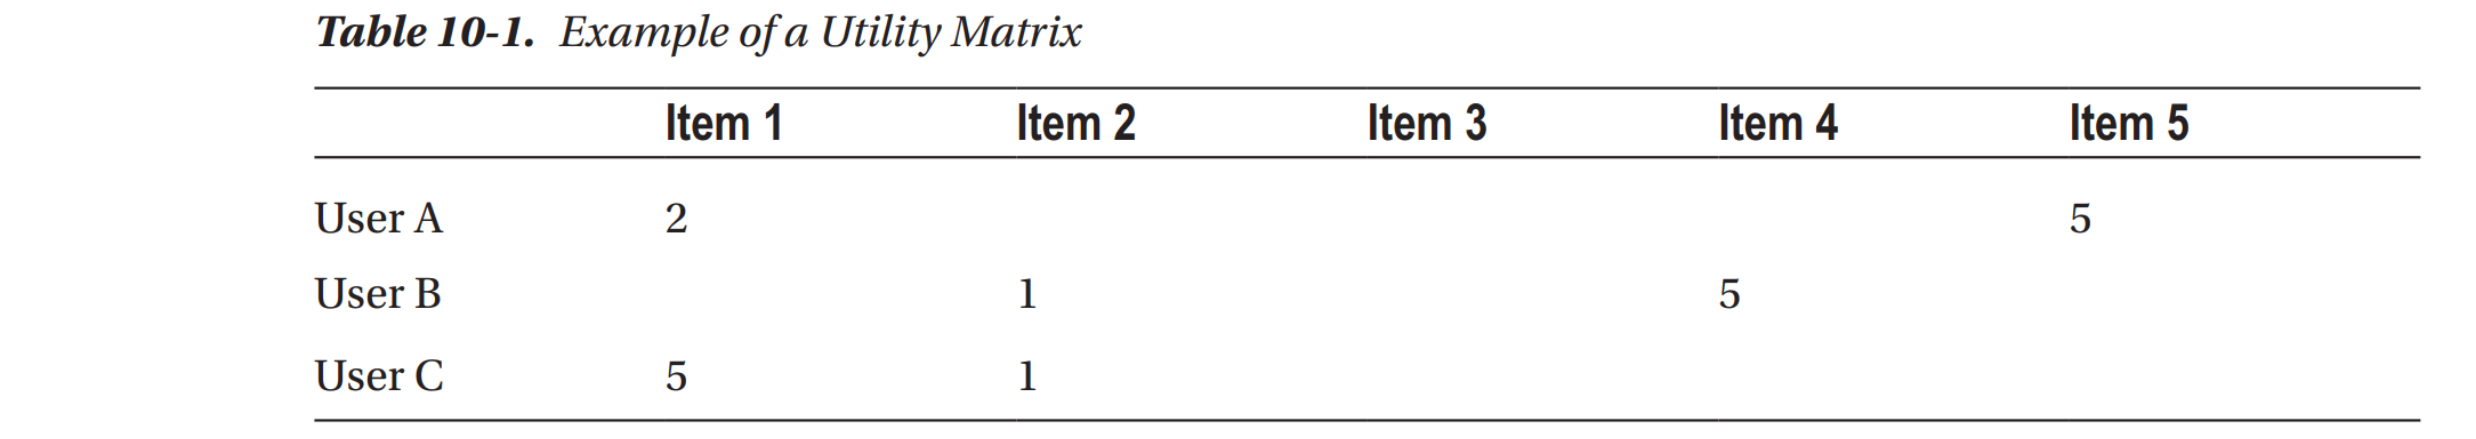

Notice that we have a lot of missing values in the matrix, these are the items that user hasn't bought. We can right away guess, say Item 4 is a recommendation for user C because user B and user C don't like Item 2, so it is likely they may end up liking the same items, in this case item 4

### <font color=blue>4. Matrix Factorization</font>
The process of matrix factorization means finding out a low rank approximation of the utility matrix. So we want to break down the utitlity matrix U into two low rank matrices so that we can recreate the matrix U by multiplying those two matrices. Mathematically,

                                        R = U * I.t
                                   and |R| = |U| * |I|
                                   
Here R is our original rating matrix, U is our user matrix, and I is our item matrix. Assuming the process helps us identify K latent features, our aim is to find two matrices X and Y such that their product (matrix multiplication) approximates R
+ X = |U| x K matrix (a matrix with dimensions of num_users * factors)
+ Y = |P| x K matrix (a matrix with dimensions of factors * num_movies)

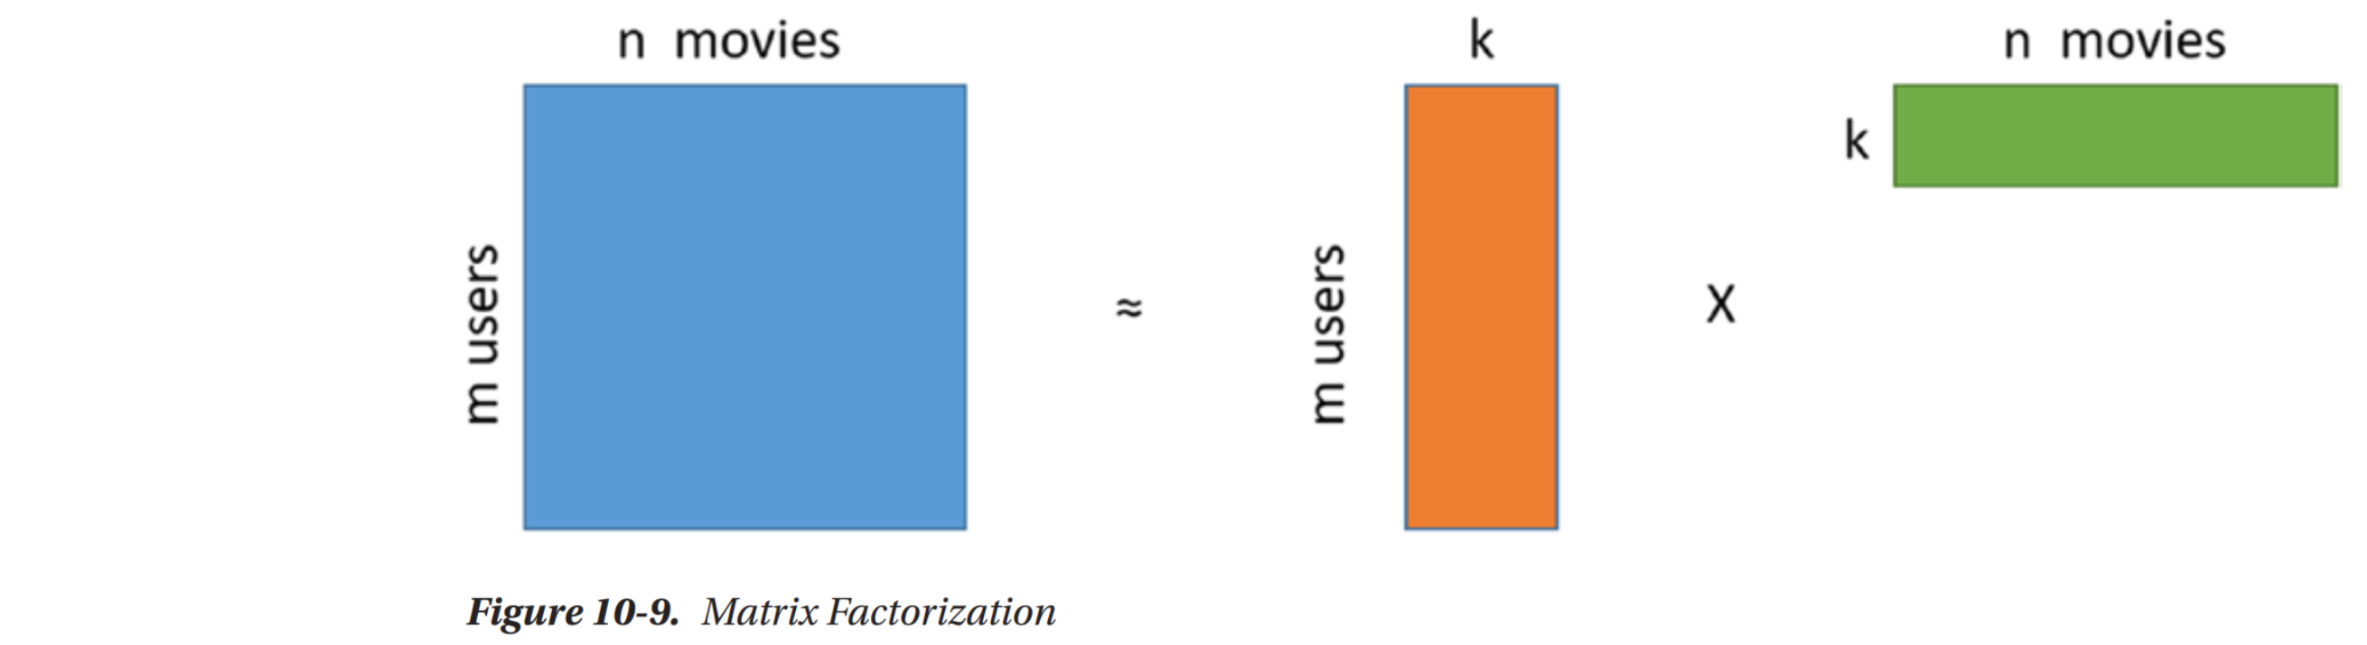

We can also try to explain the concept of matrix factorization as an image. Base on the above figure, we can generate the original matrix by multiplying the two matrices together. To make a recommendation to the user, we can multiply the corresponding user's row from the first matrix by the item matirx and determine the items from the row with maximum ratings. That will become our recommendations for the user. 
+ The first matrix represents the association between the users and the latent features
+ The second matrix take cares of the association between items and the latent features.

### <font color=blue>5. Sparsity</font> 
When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the  user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

In [234]:
df_ratings.head()

,userId,movieId,rating,timestamp,user_index,movie_index
0,2,10,4.000,835355493,0,0
1,2,17,5.000,835355681,0,1
2,2,39,5.000,835355604,0,2
3,2,47,4.000,835355552,0,3
4,2,50,4.000,835355586,0,4


In [235]:
n_users = df_ratings['userId'].nunique()
n_items = df_ratings['movieId'].nunique()

sparsity=round(1.0-len(df_ratings)/float(n_users*n_items),3)
print('The sparsity level of dataset is ' + str(sparsity*100) + '%')

The sparsity level of dataset is 79.9%


## <font color=red>8.2. Matrix Factorization and Singular Value Decomposion (SVD)</font> 

A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborating Filtering can be formulated by approximating a matrix `X` by usign singular value decomposition

Considering a matrix X having dimensions mxn such that m denotes total rows and n denotes total columns, the SVD of the matrix can be represented with the following equation

                                                    X=USV.t

Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space. Elements on the diagnoal in `S` are known as *singular values of `X`*. 

Now you can make a prediction by taking dot product of *`U`*, *`S`* and *`V^T`*.

### <font color=blue>1. Example

In [236]:
X = np.array([[1, 5, 2],
              [4, 7, 4],
              [2, 0, 9]])

U, S, Vt = np.linalg.svd(X)
print("Gettingg SVD outputs: \n")
print('U:\n', U, '\n')
print('S:\n', S, '\n')
print('Vt:\n', Vt, '\n')

comps = np.arange(0, 3)
X_pred = U[:,comps]@np.diag(S[comps])@Vt[comps,:]
X_pred

Gettingg SVD outputs: 

U:
 [[ 0.3831556  -0.39279153  0.83600634]
 [ 0.68811254 -0.48239977 -0.54202545]
 [ 0.61619228  0.78294653  0.0854506 ]] 

S:
 [12.10668383  6.91783499  1.25370079] 

Vt:
 [[ 0.36079164  0.55610321  0.74871798]
 [-0.10935467 -0.7720271   0.62611158]
 [-0.92621323  0.30777163  0.21772844]] 



array([[ 1.00000000e+00,  5.00000000e+00,  2.00000000e+00],
       [ 4.00000000e+00,  7.00000000e+00,  4.00000000e+00],
       [ 2.00000000e+00, -5.71963677e-16,  9.00000000e+00]])

### <font color=blue>2. Data Preparation

In [250]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
df_ratings = df_ratings.reset_index(drop=True)

M = df_ratings['movieId'].nunique()
N = df_ratings['userId'].nunique()

# saving original userId and movieId
uid = df_ratings['userId'].unique()
mid = df_ratings['movieId'].unique()

# create new userId and movieId
udx = np.arange(N)
mdx = np.arange(M)

# map ids and their indices
udx2uid = dict(zip(udx, uid))
uid2udx = dict(zip(uid, udx))
mdx2mid = dict(zip(mdx, mid))
mid2mdx = dict(zip(mid, mdx))

# apply index to dataframe
df_ratings['user_index'] = df_ratings.apply(lambda x:uid2udx[x['userId']], axis=1)
df_ratings['movie_index'] = df_ratings.apply(lambda x:mid2mdx[x['movieId']], axis=1)

df_ratings.head()

,userId,movieId,rating,timestamp,user_index,movie_index
0,2,10,4.000,835355493,0,0
1,2,17,5.000,835355681,0,1
2,2,39,5.000,835355604,0,2
3,2,47,4.000,835355552,0,3
4,2,50,4.000,835355586,0,4


###  <font color=blue>3. Split data

The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings. 
Since we have split the data into testing and training we will need to create two matrices (all users by all movies). 

In [251]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn

train_data, test_data = train_test_split(df_ratings[['user_index', 'movie_index', 'rating']], test_size=0.2)

# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((N, M))
for line in train_data.itertuples():
    train_data_matrix[line[1], line[2]] = line[3]
    
test_data_matrix = np.zeros((N, M))
for line in test_data.itertuples():
    test_data_matrix[line[1], line[2]] = line[3]
    
train_data_matrix.shape, test_data_matrix.shape

((427, 444), (427, 444))

### <font color=blue>3.  SVD - Using numpy library

In [238]:
U, S, Vt = np.linalg.svd(train_data_matrix)

print(U.shape, S.shape, Vt.shape)
S[0:10]

(427, 427) (427,) (444, 444)


array([357.95928405, 136.42856079, 123.50532506,  98.97193377,
        90.22573489,  81.39495631,  76.47560802,  71.06702569,
        66.2879499 ,  64.62291582])

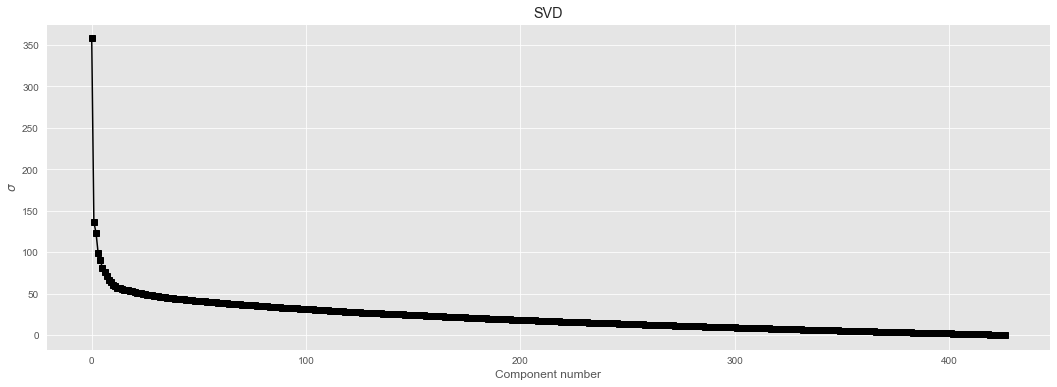

In [239]:
plt.figure(figsize=(18,6))
plt.plot(S, 'ks-')
plt.xlabel("Component number")
plt.ylabel('$\sigma$')
plt.title('SVD')
plt.show()

In [254]:

Vt[0:10,:].shape

(10, 444)

In [240]:
comps = np.arange(0,30)
pred_mt = U[:,comps]@np.diag(S[comps])@Vt[comps,:]

print(rmse(pred_mt, train_data_matrix))
print(rmse(pred_mt, test_data_matrix))

pred_mt

prediction:
[1.61264277 1.07036288 2.059285   1.81936917 0.40992109 3.19194532
 3.5282964  1.77131582 1.6896784  2.43677952]
actual:
[4. 5. 5. 4. 3. 4. 5. 4. 3. 3.]
1.953633633378261
prediction:
[1.39875572 0.37818506 1.29722538 1.5531258  0.98632968 1.05999877
 1.04185544 1.80968943 1.79556999 1.45162178]
actual:
[4. 3. 3. 3. 3. 3. 5. 5. 3. 3.]
2.8267149160660985


array([[ 1.61264277,  1.07036288,  2.059285  , ...,  0.82367979,
        -0.01519977,  1.11514677],
       [ 0.31178851, -0.1384046 ,  0.31204156, ...,  0.03693495,
        -0.07084778,  0.0357149 ],
       [ 0.80946557, -0.61762264,  1.21340115, ...,  0.68252768,
         1.06706399,  0.20504018],
       ...,
       [ 0.394482  , -0.04595619,  2.03695427, ...,  1.6666319 ,
         0.48198546,  0.49791323],
       [ 0.45923394,  1.74579268,  1.25055613, ...,  0.39124737,
         0.2283115 ,  0.503967  ],
       [ 0.13900216,  0.87493038,  1.26692195, ..., -0.29405464,
         0.75033361, -0.28446011]])

In [241]:
for n in [10, 20, 50, 80, 100]:
    print('n: ', n)
    comps = np.arange(0, n)
    pred_mt = U[:,comps]@np.diag(S[comps])@Vt[comps,:]
    print('Train set')
    print(rmse(pred_mt, train_data_matrix))
    print('Test set')
    print(rmse(pred_mt, test_data_matrix)) 
    print()

n:  10
Train set
prediction:
[1.25150021 1.28944997 1.63941868 2.00033596 0.48917992 2.34495575
 3.06482357 1.79647908 1.58679267 2.0999299 ]
actual:
[4. 5. 5. 4. 3. 4. 5. 4. 3. 3.]
2.3227247227437577
Test set
prediction:
[1.32667892 0.97948324 1.18385836 1.50534474 0.94416753 0.97597091
 0.84541755 1.94066658 2.53340041 1.18297533]
actual:
[4. 3. 3. 3. 3. 3. 5. 5. 3. 3.]
2.5726784243277527

n:  20
Train set
prediction:
[1.51318308 1.05699029 2.0389017  1.96727586 0.26353672 3.39782165
 2.83788252 1.80574258 1.77220981 2.41348714]
actual:
[4. 5. 5. 4. 3. 4. 5. 4. 3. 3.]
2.1170608322346767
Test set
prediction:
[0.98236688 0.69810332 1.32489346 1.51801864 0.97909405 1.06666517
 1.09681774 2.06348273 2.3141679  1.32288914]
actual:
[4. 3. 3. 3. 3. 3. 5. 5. 3. 3.]
2.6881460615984243

n:  50
Train set
prediction:
[1.86179061 1.63432944 2.54918755 1.32451583 0.26725268 2.89165954
 3.14735545 2.00719752 1.92987123 2.57443749]
actual:
[4. 5. 5. 4. 3. 4. 5. 4. 3. 3.]
1.6779979082461123
Test set


---
---

# <div class="alert alert-info"> 10. Hybrid Filter </div>

In [260]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
df_ratings = df_ratings.reset_index(drop=True)
df_ratings.head()

M = df_ratings['movieId'].nunique()
N = df_ratings['userId'].nunique()

# saving original userId and movieId
uid = df_ratings['userId'].unique()
mid = df_ratings['movieId'].unique()

# create new userId and movieId
udx = np.arange(N)
mdx = np.arange(M)

# map ids and their indices
udx2uid = dict(zip(udx, uid))
uid2udx = dict(zip(uid, udx))
mdx2mid = dict(zip(mdx, mid))
mid2mdx = dict(zip(mid, mdx))

# apply index to dataframe
df_ratings['user_index'] = df_ratings.apply(lambda x:uid2udx[x['userId']], axis=1)
df_ratings['movie_index'] = df_ratings.apply(lambda x:mid2mdx[x['movieId']], axis=1)

df_movies = df_movies[df_movies.movieId.isin(mid2mdx.keys())]
df_movies['movie_index'] = df_movies.apply(lambda x:mid2mdx[x['movieId']], axis=1)

In [261]:
MovieID = 318
MovieIndex = mid2mdx[MovieID]
print(MovieID, MovieIndex)

df_movies.loc[df_movies.movieId == MovieID,]

318 55


,movieId,title,genres,movie_rating,movie_count,tag,document,movie_index
284,318,"Shawshank Redemption, The (1994)",Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...,Crime Drama {friendship Morgan Freeman narrate...,55


In [262]:
path = "ml-latest-small/"

content_embeddings = pd.read_pickle(os.path.join(f'{path}movie_tfidf_embeddings.pkl'))
content_embeddings = pd.DataFrame(content_embeddings)
print(content_embeddings.shape)
content_embeddings.head()

(9125, 25)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.078,-0.078,-0.033,0.042,0.316,0.122,-0.175,0.313,0.061,0.093,-0.186,0.141,-0.179,0.106,-0.123,0.054,-0.190,0.109,0.084,-0.054,0.006,-0.017,-0.070,-0.139,0.181
1,-0.094,-0.036,0.072,0.046,0.425,0.220,-0.274,0.295,0.166,0.247,-0.082,0.039,-0.169,0.121,-0.042,-0.047,-0.116,0.034,-0.094,0.074,0.230,-0.025,-0.103,-0.327,0.198
2,0.142,0.109,0.117,-0.113,0.011,0.170,-0.182,0.480,-0.102,-0.191,-0.404,-0.094,0.066,-0.058,0.056,-0.035,-0.375,0.270,-0.099,0.231,-0.078,-0.101,0.057,0.118,0.000
3,0.051,0.180,0.053,-0.145,0.041,0.153,-0.263,0.378,0.056,-0.105,-0.429,-0.097,0.030,-0.038,0.116,0.021,-0.433,0.197,-0.060,0.212,-0.201,-0.217,0.149,0.215,0.102
4,0.042,0.098,0.020,-0.039,0.048,0.039,-0.027,0.174,-0.077,0.005,-0.083,0.012,0.004,0.002,-0.024,-0.039,-0.136,0.084,0.045,-0.075,-0.003,-0.035,0.037,-0.010,0.152


In [263]:
content_embeddings_cols = content_embeddings.columns
content_embeddings['movieId'] = df_movies['movieId']
content_embeddings = content_embeddings[content_embeddings.movieId.isin(mid2mdx.keys())]
content_embeddings['movie_index'] = content_embeddings.apply(lambda x:mid2mdx[x['movieId']], axis=1)
content_embeddings = content_embeddings.sort_values(['movie_index'])

print(content_embeddings.shape)
content_embeddings[content_embeddings.movieId == MovieID]

(444, 27)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,movieId,movie_index
284,0.069,0.052,0.104,-0.052,0.026,0.085,-0.073,0.085,-0.049,0.006,-0.007,-0.064,-0.046,0.010,0.048,-0.012,-0.159,0.038,0.058,-0.106,0.062,-0.006,0.072,0.041,0.130,318.000,55


In [264]:
Vt[0:10,:].shape

(10, 444)

In [265]:
#cf_movie_embeddings  = pd.read_pickle('ml-latest-small/cf_movie_embeddings.pkl')
cf_movie_embeddings  = pd.DataFrame(Vt[0:10,:].T)
print(cf_movie_embeddings .shape)
cf_movie_embeddings .head()

(444, 10)


,0,1,2,3,4,5,6,7,8,9
0,-0.034,-0.014,0.070,-0.012,-0.037,0.027,0.024,-0.036,0.018,-0.028
1,-0.027,-0.063,0.010,-0.032,0.034,-0.066,0.011,-0.040,0.014,-0.052
2,-0.048,-0.065,0.043,-0.010,0.085,-0.021,0.032,0.046,-0.009,-0.027
3,-0.090,-0.013,0.058,-0.122,-0.050,0.058,0.027,0.042,0.035,0.028
4,-0.089,-0.030,-0.012,-0.113,-0.020,0.031,-0.059,0.125,0.170,0.014


### Recommendations

In [266]:
def get_detailed_recs(movie_index, embeddings, df_movies):
    #get similar movies
    similarity_matrix = cosine_similarity(embeddings)
    item_sim_df = pd.DataFrame(similarity_matrix[movie_index])
    item_sim_df =  item_sim_df.reset_index(drop=False)
    item_sim_df.columns = ['movie_index', 'similarity_score']
    # assign movie_index
    item_sim_df['movie_index'] = sorted(mdx2mid.keys())
    # merge with table item_data to get the description info
    item_sim_df = item_sim_df.merge(df_movies, left_on='movie_index', right_on = 'movie_index', how='left')
    # sort similarity score in descending order
    item_sim_df = item_sim_df.sort_values('similarity_score', ascending=False)
    item_sim_df.reset_index(drop=True, inplace=True)  

    return item_sim_df

In [267]:
MovieIndex

55

### Content Recommendations

In [268]:
CT_sim_df = get_detailed_recs(MovieIndex, content_embeddings[content_embeddings_cols], df_movies)
CT_sim_df.head(10)

,movie_index,similarity_score,movieId,title,genres,movie_rating,movie_count,tag,document
0,55,1.000,318,"Shawshank Redemption, The (1994)",Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...,Crime Drama {friendship Morgan Freeman narrate...
1,368,0.867,3160,Magnolia (1999),Drama,3.693,57.000,{Ei muista},Drama {Ei muista}
2,304,0.833,1059,William Shakespeare's Romeo + Juliet (1996),Drama Romance,3.526,58.000,{claire daines clever Leonardo DiCaprio shakes...,Drama Romance {claire daines clever Leonardo D...
3,234,0.830,2329,American History X (1998),Crime Drama,4.023,107.000,{Ei muista},Crime Drama {Ei muista}
4,90,0.822,858,"Godfather, The (1972)",Crime Drama,4.487,200.000,{Katso Sanna!},Crime Drama {Katso Sanna!}
5,351,0.810,2396,Shakespeare in Love (1998),Comedy Drama Romance,3.967,121.000,{colin firth Gwenth Paltrow joseph fiennes},Comedy Drama Romance {colin firth Gwenth Paltr...
6,68,0.804,3949,Requiem for a Dream (2000),Drama,3.870,69.000,{Ei muista addiction psychology},Drama {Ei muista addiction psychology}
7,226,0.803,1358,Sling Blade (1996),Drama,3.886,66.000,{billy bob thorton},Drama {billy bob thorton}
8,240,0.797,4011,Snatch (2000),Comedy Crime Thriller,4.037,95.000,{Ei muista Guy Ritchie twist ending},Comedy Crime Thriller {Ei muista Guy Ritchie t...
9,231,0.788,1704,Good Will Hunting (1997),Drama Romance,4.140,157.000,{genius intellectual mathematics psychology},Drama Romance {genius intellectual mathematics...


### Collaborative Recommendations

In [269]:
CF_sim_df = get_detailed_recs(MovieIndex, cf_movie_embeddings, df_movies)
CF_sim_df.head(10)

,movie_index,similarity_score,movieId,title,genres,movie_rating,movie_count,tag,document
0,55,1.000,318,"Shawshank Redemption, The (1994)",Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...,Crime Drama {friendship Morgan Freeman narrate...
1,53,0.830,593,"Silence of the Lambs, The (1991)",Crime Horror Thriller,4.138,304.000,{Katso Sanna!},Crime Horror Thriller {Katso Sanna!}
2,44,0.822,527,Schindler's List (1993),Drama War,4.303,244.000,{},Drama War {}
3,28,0.812,356,Forrest Gump (1994),Comedy Drama Romance War,4.054,341.000,{},Comedy Drama Romance War {}
4,7,0.771,110,Braveheart (1995),Action Drama War,3.945,228.000,{},Action Drama War {}
5,22,0.714,296,Pulp Fiction (1994),Comedy Crime Drama Thriller,4.256,324.000,{intense r:violence tarantino dark comedy Quen...,Comedy Crime Drama Thriller {intense r:violenc...
6,209,0.653,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.872,247.000,{Pixar},Adventure Animation Children Comedy Fantasy {P...
7,63,0.614,2028,Saving Private Ryan (1998),Action Drama War,3.945,191.000,{afi hdtv holes90s},Action Drama War {afi hdtv holes90s}
8,231,0.612,1704,Good Will Hunting (1997),Drama Romance,4.140,157.000,{genius intellectual mathematics psychology},Drama Romance {genius intellectual mathematics...
9,233,0.576,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy Drama Romance War,4.025,99.000,{},Comedy Drama Romance War {}


In [270]:
df_movies.head()

,movieId,title,genres,movie_rating,movie_count,tag,document,movie_index
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.872,247.000,{Pixar},Adventure Animation Children Comedy Fantasy {P...,209
1,2,Jumanji (1995),Adventure Children Fantasy,3.402,107.000,{},Adventure Children Fantasy {},269
2,3,Grumpier Old Men (1995),Comedy Romance,3.161,59.000,{},Comedy Romance {},165
4,5,Father of the Bride Part II (1995),Comedy,3.268,56.000,{steve martin},Comedy {steve martin},270
5,6,Heat (1995),Action Crime Thriller,3.885,104.000,{},Action Crime Thriller {},271


### Averaged Ensemble Recommendations

In [271]:
def get_ensemble_recs(MovieIndex, content_embeddings, collaborative_embeddings, df_movies):
    #get similar movies from content
    CT_sim_df = get_detailed_recs(MovieIndex, content_embeddings[content_embeddings_cols], df_movies)
    CT_sim_df.rename(columns={'similarity_score':'content_score'}, inplace=True)

    #get similar movies from collaborative
    CF_sim_df = get_detailed_recs(MovieIndex, cf_movie_embeddings, df_movies)
    CF_sim_df.rename(columns={'similarity_score':'collaborative_score'}, inplace=True)
    
    #ensemble results
    result_df = df_movies.copy()
    result_df = pd.merge(result_df, CT_sim_df[['movieId','content_score']], how='left', on='movieId')
    result_df = pd.merge(result_df, CF_sim_df[['movieId','collaborative_score']], how='left', on='movieId')
    result_df['average_score'] = (result_df['content_score'] + result_df['collaborative_score'])/2
    result_df.sort_values('average_score', ascending=False, inplace=True)

    return result_df

In [272]:
ens_rec = get_ensemble_recs(MovieIndex, content_embeddings[content_embeddings_cols], cf_movie_embeddings, df_movies)
ens_rec.head(10)

,movieId,title,genres,movie_rating,movie_count,tag,document,movie_index,content_score,collaborative_score,average_score
56,318,"Shawshank Redemption, The (1994)",Crime Drama,4.487,311.000,{friendship Morgan Freeman narrated prison pri...,Crime Drama {friendship Morgan Freeman narrate...,55,1.000,1.000,1.000
105,593,"Silence of the Lambs, The (1991)",Crime Horror Thriller,4.138,304.000,{Katso Sanna!},Crime Horror Thriller {Katso Sanna!},53,0.685,0.830,0.757
92,527,Schindler's List (1993),Drama War,4.303,244.000,{},Drama War {},44,0.665,0.822,0.743
52,296,Pulp Fiction (1994),Comedy Crime Drama Thriller,4.256,324.000,{intense r:violence tarantino dark comedy Quen...,Comedy Crime Drama Thriller {intense r:violenc...,22,0.691,0.714,0.703
281,2329,American History X (1998),Crime Drama,4.023,107.000,{Ei muista},Crime Drama {Ei muista},234,0.830,0.571,0.701
244,1704,Good Will Hunting (1997),Drama Romance,4.140,157.000,{genius intellectual mathematics psychology},Drama Romance {genius intellectual mathematics...,231,0.788,0.612,0.700
65,356,Forrest Gump (1994),Comedy Drama Romance War,4.054,341.000,{},Comedy Drama Romance War {},28,0.572,0.812,0.692
24,110,Braveheart (1995),Action Drama War,3.945,228.000,{},Action Drama War {},7,0.491,0.771,0.631
265,2028,Saving Private Ryan (1998),Action Drama War,3.945,191.000,{afi hdtv holes90s},Action Drama War {afi hdtv holes90s},63,0.645,0.614,0.630
128,858,"Godfather, The (1972)",Crime Drama,4.487,200.000,{Katso Sanna!},Crime Drama {Katso Sanna!},90,0.822,0.420,0.621


# 4 Accept user input

In [226]:
df_user = df_ratings[['movieId', 'userId']]

In [227]:
from ipywidgets import widgets

In [228]:
def handle_submit(sender):
    global movieid
    if text.value != '':
        df_user[movieid] = text.value
    clear_output()
    movieid = show_movie()
    text.value = ''
    

def show_movie():
    global movies
    movie = df_movies.sample(1)
    movies = df_movies.drop(movie.index)
    print('number of movies unrated: ' + str(movies.shape[0]) + '\n')
    print(movie)
    
    return movie['movieId'].values[0]

In [229]:
text = widgets.Text()
random_state = 123456789
display(text)
text.on_submit(handle_submit)

movieid = show_movie()

Text(value='')

number of movies unrated: 443

      movieId                   title genres  movie_rating  movie_count tag  document  movie_index
2719     3408  Erin Brockovich (2000)  Drama         3.553       85.000  {}  Drama {}          190


### 

---
---

# <div class="alert alert-info"> 9. CF-DNN based Recommendataion Engine</div>

---
##  <font color=red>Model-baed CF: Deep Learning</font>

https://github.com/alineberry/my-movie-recommender/blob/master/notebooks/movie_similarity/neural-net-movie-embedding.ipynb

A fully connected NN is used to find movie and user embeddings. In this architecture, a user embedding matrix of size (n_users, n_factors) and a movie embedding matrix of size (n_movies, n_factors) are randomly initalized and subsequently learned via gradient descent. The user and movie indices are used to lookup the embedding vectors (which are rows of the embedding matrices). These vectors are then concatenated and passed in as the input to the neural net

In [693]:
df_ratings = pd.read_csv('ml-latest-small/ratings_filtered.csv')
df_ratings = df_ratings.reset_index(drop=True)
df_ratings.head()

M = df_ratings['movieId'].nunique()
N = df_ratings['userId'].nunique()

# saving original userId and movieId
uid = df_ratings['userId'].unique()
mid = df_ratings['movieId'].unique()

# create new userId and movieId
udx = np.arange(N)
mdx = np.arange(M)

# map ids and their indices
udx2uid = dict(zip(udx, uid))
uid2udx = dict(zip(uid, udx))
mdx2mid = dict(zip(mdx, mid))
mid2mdx = dict(zip(mid, mdx))

# apply index to dataframe
df_ratings['user_index'] = df_ratings.apply(lambda x:uid2udx[x['userId']], axis=1)
df_ratings['movie_index'] = df_ratings.apply(lambda x:mid2mdx[x['movieId']], axis=1)

df_movies = df_movies[df_movies.movieId.isin(mid2mdx.keys())]
df_movies['movie_index'] = df_movies.apply(lambda x:mid2mdx[x['movieId']], axis=1)

In [694]:
path = "ml-latest-small/"

content_embeddings = pd.read_pickle(os.path.join(f'{path}movie_tfidf_embeddings.pkl'))
content_embeddings = pd.DataFrame(content_embeddings)
content_embeddings_cols = ['i_' + str(i) for i in content_embeddings.columns]
content_embeddings.columns = content_embeddings_cols
print(content_embeddings.shape)
content_embeddings.head()

(9125, 25)


,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,i_10,i_11,i_12,i_13,i_14,i_15,i_16,i_17,i_18,i_19,i_20,i_21,i_22,i_23,i_24
0,0.078,-0.078,-0.033,0.042,0.316,0.122,-0.175,0.313,0.061,0.093,-0.186,0.141,-0.179,0.106,-0.123,0.054,-0.190,0.109,0.084,-0.054,0.006,-0.017,-0.070,-0.139,0.181
1,-0.094,-0.036,0.072,0.046,0.425,0.220,-0.274,0.295,0.166,0.247,-0.082,0.039,-0.169,0.121,-0.042,-0.047,-0.116,0.034,-0.094,0.074,0.230,-0.025,-0.103,-0.327,0.198
2,0.142,0.109,0.117,-0.113,0.011,0.170,-0.182,0.480,-0.102,-0.191,-0.404,-0.094,0.066,-0.058,0.056,-0.035,-0.375,0.270,-0.099,0.231,-0.078,-0.101,0.057,0.118,0.000
3,0.051,0.180,0.053,-0.145,0.041,0.153,-0.263,0.378,0.056,-0.105,-0.429,-0.097,0.030,-0.038,0.116,0.021,-0.433,0.197,-0.060,0.212,-0.201,-0.217,0.149,0.215,0.102
4,0.042,0.098,0.020,-0.039,0.048,0.039,-0.027,0.174,-0.077,0.005,-0.083,0.012,0.004,0.002,-0.024,-0.039,-0.136,0.084,0.045,-0.075,-0.003,-0.035,0.037,-0.010,0.152


In [695]:
content_embeddings_cols = content_embeddings.columns
content_embeddings['movieId'] = df_movies['movieId']
content_embeddings = content_embeddings[content_embeddings.movieId.isin(mid2mdx.keys())]
content_embeddings['movie_index'] = content_embeddings.apply(lambda x:mid2mdx[x['movieId']], axis=1)
content_embeddings = content_embeddings.sort_values(['movie_index'])

print(content_embeddings.shape)
content_embeddings[content_embeddings.movieId == MovieID]

(444, 27)


,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,i_10,i_11,i_12,i_13,i_14,i_15,i_16,i_17,i_18,i_19,i_20,i_21,i_22,i_23,i_24,movieId,movie_index
284,0.069,0.052,0.104,-0.052,0.026,0.085,-0.073,0.085,-0.049,0.006,-0.007,-0.064,-0.046,0.010,0.048,-0.012,-0.159,0.038,0.058,-0.106,0.062,-0.006,0.072,0.041,0.130,318.000,55


In [696]:
df = pd.read_csv('ml-latest-small/user_movie_profife.csv')
df.fillna(0, inplace=True)
df.head()

,userId,movieId,rating,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count,Index
0,2,10,4.000,3.451,122.000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,0.000,0.000,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,0
1,2,17,5.000,3.924,86.000,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,0.000,0.000,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,1
2,2,39,5.000,3.550,120.000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,0.000,0.000,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,2
3,2,47,4.000,4.035,201.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,0.000,0.000,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,3
4,2,50,4.000,4.371,201.000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,3.438,16.000,3.800,10.000,3.750,4.000,3.500,6.000,3.050,20,3.667,9.000,0.000,0.000,3.714,28,3.500,8.000,3.500,2.000,3.750,4.000,4.000,3.000,3.692,13.000,3.750,4.000,3.474,19.000,3.800,5.000,4


In [697]:
df.shape, df_ratings.shape

((38133, 54), (38133, 6))

### Split data into train set and test set

In [698]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn

train_data, test_data = train_test_split(df.drop(['userId','movieId','rating','Index'],axis=1), test_size=0.2)

In [699]:
train_data.head()

,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count
37144,3.857,91.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.250,100.000,4.266,94.000,4.391,23.000,4.364,33.000,4.188,133,4.398,49.000,0.000,0.000,4.266,107,4.362,47.000,4.176,17.000,4.079,19.000,4.452,21.000,4.169,59.000,4.278,63.000,4.329,79.000,4.562,8.000
33664,3.881,130.000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3.779,43.000,3.972,36.000,4.500,11.000,4.143,14.000,3.536,28,3.917,24.000,0.000,0.000,4.207,46,3.889,18.000,3.643,7.000,3.667,3.000,4.667,9.000,4.156,16.000,3.955,22.000,3.779,34.000,4.188,8.000
15033,4.027,93.000,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,3.797,106.000,3.837,83.000,4.000,22.000,3.984,31.000,3.676,111,3.589,56.000,0.000,0.000,3.907,97,3.951,41.000,4.115,13.000,4.036,14.000,3.921,19.000,3.750,56.000,3.774,53.000,3.575,80.000,4.500,12.000
3939,3.323,79.000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,3.563,127.000,3.553,103.000,3.617,30.000,3.487,40.000,3.481,133,3.936,70.000,4.250,2.000,3.830,132,3.598,51.000,3.659,22.000,3.421,19.000,3.963,27.000,3.405,63.000,3.506,77.000,3.645,100.000,4.062,16.000
31154,3.700,65.000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.067,67.000,3.154,52.000,3.467,15.000,3.727,22.000,3.264,123,3.734,62.000,4.500,2.000,3.723,141,3.776,29.000,3.441,17.000,4.000,17.000,4.054,28.000,3.704,76.000,3.262,42.000,3.542,72.000,3.763,19.000


In [700]:
# scale training set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_df = pd.DataFrame(scaler.fit_transform(train_data))
scaled_train_df.index = train_data.index
scaled_train_df.columns = train_data.columns

scaled_test_df = pd.DataFrame(scaler.transform(test_data))
scaled_test_df.index = test_data.index
scaled_test_df.columns = train_data.columns

scaled_test_df.head(3)

,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count
31055,0.702,0.131,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.613,0.511,0.631,0.486,0.693,0.500,0.745,0.537,0.438,0.782,0.747,0.816,0.900,1.000,0.574,0.892,0.755,0.527,0.688,0.680,0.800,0.708,0.811,0.848,0.741,0.894,0.652,0.519,0.708,0.637,0.753,0.905
16151,0.346,0.190,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.760,0.473,0.778,0.505,0.800,0.400,0.843,0.512,0.651,0.526,0.803,0.434,0.000,0.000,0.709,0.420,0.811,0.509,0.767,0.240,0.815,0.542,0.800,0.364,0.832,0.553,0.789,0.333,0.769,0.425,0.783,0.286
13826,0.636,0.769,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.877,0.099,0.860,0.093,0.600,0.067,0.733,0.146,0.672,0.103,0.788,0.211,0.800,0.500,0.755,0.306,0.833,0.109,1.000,0.040,0.700,0.167,0.760,0.303,0.862,0.153,0.914,0.086,0.783,0.204,0.943,0.333


In [701]:
X_train = scaled_train_df
y_train = df.loc[train_data.index]['rating']

X_test = scaled_test_df
y_test = df.loc[scaled_test_df.index]['rating']

'''
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
'''

'\nX_train = X_train.reset_index(drop=True)\ny_train = y_train.reset_index(drop=True)\nX_test = X_test.reset_index(drop=True)\ny_test = y_test.reset_index(drop=True)\n'

In [702]:
X_train.head()

,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count
37144,0.706,0.138,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.850,0.763,0.853,0.879,0.878,0.767,0.873,0.805,0.757,0.846,0.880,0.645,0.000,0.000,0.755,0.675,0.872,0.855,0.835,0.680,0.816,0.792,0.890,0.636,0.834,0.694,0.856,0.778,0.866,0.699,0.913,0.381
33664,0.717,0.272,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.756,0.328,0.794,0.336,0.900,0.367,0.829,0.341,0.532,0.173,0.783,0.316,0.000,0.000,0.736,0.287,0.778,0.327,0.729,0.280,0.733,0.125,0.933,0.273,0.831,0.188,0.791,0.272,0.756,0.301,0.838,0.381
15033,0.785,0.145,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.759,0.809,0.767,0.776,0.800,0.733,0.797,0.756,0.580,0.705,0.718,0.737,0.000,0.000,0.636,0.611,0.790,0.745,0.823,0.520,0.807,0.583,0.784,0.576,0.750,0.659,0.755,0.654,0.715,0.708,0.900,0.571
3939,0.457,0.097,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.713,0.969,0.711,0.963,0.723,1.000,0.698,0.976,0.513,0.846,0.787,0.921,0.850,1.000,0.610,0.834,0.720,0.927,0.732,0.880,0.684,0.792,0.793,0.818,0.681,0.741,0.701,0.951,0.729,0.885,0.812,0.762
31154,0.633,0.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.613,0.511,0.631,0.486,0.693,0.500,0.745,0.537,0.438,0.782,0.747,0.816,0.900,1.000,0.574,0.892,0.755,0.527,0.688,0.680,0.800,0.708,0.811,0.848,0.741,0.894,0.652,0.519,0.708,0.637,0.753,0.905


In [703]:
X_test.head()

,movie_rating,movie_count,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,musical,mystery,romance,scifi,thriller,war,action_rating,action_count,adventure_rating,adventure_count,animation_rating,animation_count,children_rating,children_count,comedy_rating,comedy_count,crime_rating,crime_count,documentary_rating,documentary_count,drama_rating,drama_count,fantasy_rating,fantasy_count,horror_rating,horror_count,musical_rating,musical_count,mystery_rating,mystery_count,romance_rating,romance_count,scifi_rating,scifi_count,thriller_rating,thriller_count,war_rating,war_count
31055,0.702,0.131,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.613,0.511,0.631,0.486,0.693,0.500,0.745,0.537,0.438,0.782,0.747,0.816,0.900,1.000,0.574,0.892,0.755,0.527,0.688,0.680,0.800,0.708,0.811,0.848,0.741,0.894,0.652,0.519,0.708,0.637,0.753,0.905
16151,0.346,0.190,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.760,0.473,0.778,0.505,0.800,0.400,0.843,0.512,0.651,0.526,0.803,0.434,0.000,0.000,0.709,0.420,0.811,0.509,0.767,0.240,0.815,0.542,0.800,0.364,0.832,0.553,0.789,0.333,0.769,0.425,0.783,0.286
13826,0.636,0.769,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.877,0.099,0.860,0.093,0.600,0.067,0.733,0.146,0.672,0.103,0.788,0.211,0.800,0.500,0.755,0.306,0.833,0.109,1.000,0.040,0.700,0.167,0.760,0.303,0.862,0.153,0.914,0.086,0.783,0.204,0.943,0.333
3729,0.806,0.279,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.713,0.969,0.711,0.963,0.723,1.000,0.698,0.976,0.513,0.846,0.787,0.921,0.850,1.000,0.610,0.834,0.720,0.927,0.732,0.880,0.684,0.792,0.793,0.818,0.681,0.741,0.701,0.951,0.729,0.885,0.812,0.762
21259,0.641,0.521,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.637,0.206,0.600,0.121,0.000,0.000,0.600,0.049,0.482,0.173,0.830,0.263,0.400,0.500,0.627,0.210,0.567,0.109,0.733,0.120,0.000,0.000,0.800,0.121,0.678,0.212,0.620,0.123,0.786,0.257,0.760,0.238


### Define DNN architecture

In [704]:
# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

def performance_evaluation(X_train, X_test, y_train, y_test, model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print('Train mse: {}'.format(mean_squared_error(y_train, pred_train)))
    print('Train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
    print()
    print('Test mse: {}'.format(mean_squared_error(y_test, pred_test)))
    print('Test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

In [705]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [706]:
def dnn_model(input_dim, dim1,n_epochs, batch_size):   
    keras.backend.clear_session()
    tf.keras.backend.clear_session
    tf.random.set_seed(9)
    np.random.seed(9)
    
    dnn = Sequential()
    dnn.add(Dense(dim1, input_dim=input_dim, activation='relu'))
    dnn.add(Dense(50, activation='relu'))
    dnn.add(Dense(1, activation='relu'))
    print(dnn.summary())
    
    dnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
    t_ini = datetime.datetime.now()
    history = dnn.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, validation_split=0.2)
    t_fin = datetime.datetime.now()
    print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
    plot_history(history)
    performance_evaluation(X_train, X_test, y_train.values, y_test.values, dnn)

    return dnn

In [707]:
def plot_history(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,626
Trainable params: 2,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
763/763 [==============================] - 3s 3ms/step - loss: 1.2164 - mae: 0.7936 - val_loss: 0.7722 - val_mae: 0.6790
Epoch 2/30
763/763 [==============================] - 2s 3ms/step - loss: 0.7227 - mae: 0.6516 - val_loss: 0.7509 - val_mae: 0.6557
Epoch 3/30
763/763 [==============================] - 3s 3ms/step - loss: 0.7055 - mae: 0.6432 - val_loss: 0.7564 -

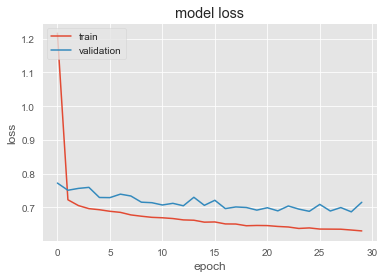

Train mse: 0.6592165352812973
Train rmse: 0.8119215080790121

Test mse: 0.6699177585209964
Test rmse: 0.8184850386665576


In [687]:
dnn = dnn_model(len(X_train.columns), 25, n_epochs=30, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 4,111
Trainable params: 4,111
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
763/763 [==============================] - 4s 4ms/step - loss: 1.0804 - mae: 0.7584 - val_loss: 0.7680 - val_mae: 0.6878
Epoch 2/30
763/763 [==============================] - 2s 3ms/step - loss: 0.7112 - mae: 0.6473 - val_loss: 0.7337 - val_mae: 0.6494
Epoch 3/30
763/763 [==============================] - 2s 2ms/step - loss: 0.6986 - mae: 0.6404 - val_loss: 0.7302 -

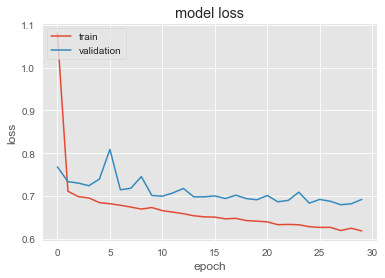

Train mse: 0.6299695804613215
Train rmse: 0.7937062305798799

Test mse: 0.6424430582898889
Test rmse: 0.8015254570441845


In [730]:

    tf.random.set_seed(42)
    np.random.seed(42)
    keras.backend.clear_session()
    
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=len(scaled_train_df.columns), activation='relu'))
    dnn.add(Dense(30, activation='relu'))
    dnn.add(Dense(1, activation='relu'))
    print(dnn.summary())
    
    dnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
    t_ini = datetime.datetime.now()
    history = dnn.fit(X_train, y_train, epochs=30, batch_size=0,  verbose=1, validation_split=0.2)
    t_fin = datetime.datetime.now()
    print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
    plot_history(history)
    performance_evaluation(X_train, X_test, y_train, y_test, dnn)


In [731]:
y_pred = dnn.predict(X_test)
y_pred.ravel()

array([3.679225, 3.352927, 3.851208, ..., 3.812777, 2.359305, 3.094673],
      dtype=float32)

In [732]:
y_pred = dnn.predict(X_test).ravel()
y_pred[11:20]

array([4.108962 , 2.66345  , 4.366827 , 2.699925 , 2.4580798, 3.852704 ,
       3.9789515, 4.5236077, 4.269942 ], dtype=float32)

In [733]:
np.round(y_pred[11:50],1)

array([4.1, 2.7, 4.4, 2.7, 2.5, 3.9, 4. , 4.5, 4.3, 3.9, 4.5, 4.3, 3.8,
       3.2, 4. , 3.9, 4. , 3.6, 4.2, 3.1, 3.8, 4. , 4.6, 3.7, 3.6, 4.3,
       4.5, 4.2, 3.9, 4.3, 2.9, 3.7, 2.9, 3.4, 4.1, 4. , 3.1, 3.5, 3.6],
      dtype=float32)

In [734]:
y_test.values[11:50]

array([5. , 1. , 3. , 2. , 3. , 3.5, 4. , 4.5, 4.5, 5. , 5. , 5. , 4. ,
       3. , 4.5, 4. , 4. , 5. , 2.5, 3. , 3.5, 4. , 5. , 5. , 1. , 3.5,
       5. , 4.5, 4. , 5. , 3. , 4.5, 3. , 1. , 2. , 3. , 4. , 2.5, 5. ])